# TESS Atlas fit for TOI 195

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 195.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-195.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-195.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-195.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 195

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 195 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

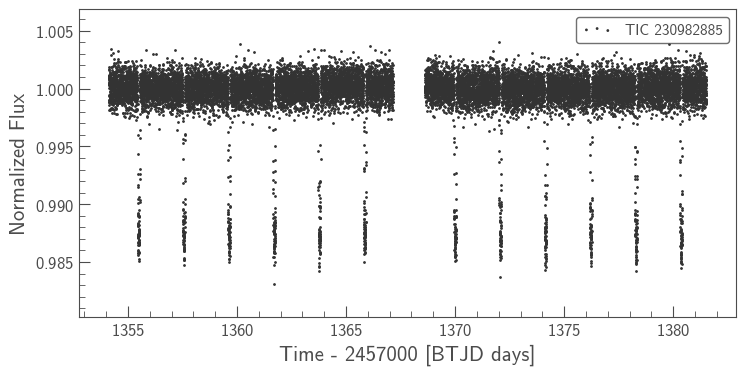

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -43744.96876477789 -> -43724.36414900619


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -27894.365898069922 -> -27012.602648007894


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -27012.60264800789 -> -25161.73343477855


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -25161.73343477855 -> -25161.73285802066


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -25161.73285802066 -> -25161.666141359965


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -25161.666141359965 -> -25161.66528119395


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -25161.66528119395 -> -24835.893162397926


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -24835.89316239793 -> -24835.89316239793


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -24835.893162397926 -> -24835.893162397926


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -24835.893162397926 -> -24835.893162397922


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -24835.893162397922 -> -24835.893162397922


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -24835.893162397922 -> -24835.893162397795


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -24835.893162397795 -> -24835.893162397795


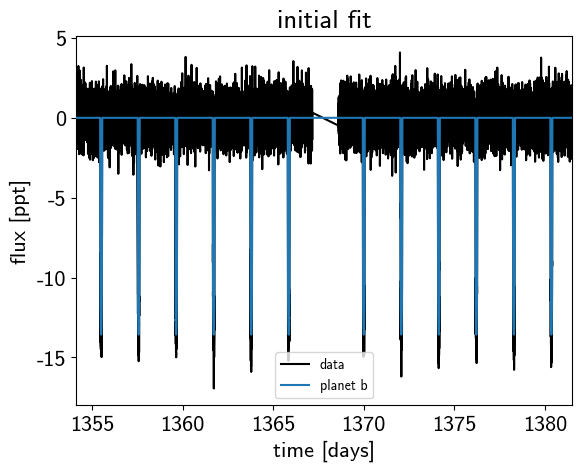

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:06, 13.33draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:15,  5.71draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:15,  5.96draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:31,  2.82draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:31,  2.75draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:25,  3.41draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:36,  2.34draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:27,  3.04draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:38,  2.16draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:36,  2.23draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:33,  2.32draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:30,  2.58draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:31,  2.44draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:26,  2.83draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:32,  2.26draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:25,  2.88draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:30,  2.34draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:25,  2.82draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:10<00:29,  2.38draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:25,  2.66draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:26,  2.53draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:11<00:26,  2.55draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:25,  2.55draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:26,  2.44draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:12<00:23,  2.68draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:26,  2.40draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:13<00:23,  2.61draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:26,  2.29draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:22,  2.66draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:14<00:26,  2.26draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:19,  2.92draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:15<00:25,  2.22draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:15<00:21,  2.65draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:16<00:23,  2.35draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:16<00:19,  2.71draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:16<00:22,  2.38draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:17<00:18,  2.81draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:17<00:23,  2.17draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:18<00:21,  2.27draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:19<00:19,  2.40draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:19<00:15,  2.96draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:19<00:18,  2.44draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:20<00:16,  2.72draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:20<00:16,  2.54draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:21<00:16,  2.53draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:21<00:16,  2.43draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:21<00:16,  2.43draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:22<00:16,  2.34draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:22<00:14,  2.66draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:23<00:15,  2.45draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:23<00:12,  2.86draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:24<00:15,  2.30draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:24<00:11,  2.96draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:24<00:14,  2.32draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:24<00:10,  2.94draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:25<00:14,  2.17draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:26<00:12,  2.29draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:26<00:09,  2.92draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:27<00:12,  2.16draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:27<00:08,  2.92draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:27<00:10,  2.39draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:28<00:08,  2.81draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:28<00:09,  2.35draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:29<00:07,  2.63draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:29<00:09,  2.19draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:29<00:06,  2.83draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:30<00:08,  2.08draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:30<00:07,  2.27draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:31<00:06,  2.36draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:32<00:07,  1.93draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:32<00:06,  2.08draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:33<00:05,  2.15draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:33<00:04,  2.47draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:34<00:03,  2.36draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:35<00:03,  2.09draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:35<00:02,  2.15draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:36<00:01,  2.60draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:36<00:02,  1.86draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:37<00:01,  1.54draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:38<00:01,  1.38draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:39<00:00,  1.64draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:41<00:00,  1.25s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:07, 12.74draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:12,  7.22draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:21,  4.15draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:24,  3.67draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:29,  3.05draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:29,  2.99draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:34,  2.52draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:30,  2.78draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:34,  2.48draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:33,  2.47draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:35,  2.34draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:27,  2.98draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:36,  2.20draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:27,  2.83draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:36,  2.16draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:26,  2.83draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:30,  2.44draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:26,  2.78draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:24,  2.97draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:23,  3.00draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:25,  2.78draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:09<00:29,  2.30draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:24,  2.79draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:31,  2.11draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:30,  2.16draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:27,  2.26draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:25,  2.38draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:13<00:24,  2.44draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:13<00:18,  3.13draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:18,  3.10draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:16,  3.33draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:15<00:23,  2.32draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:16<00:22,  2.34draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:16<00:17,  2.93draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:17<00:24,  2.04draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:18<00:20,  2.34draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:18<00:17,  2.56draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:19<00:20,  2.21draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:19<00:17,  2.46draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:19<00:15,  2.74draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:20<00:15,  2.59draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:20<00:15,  2.55draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:21<00:14,  2.62draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:21<00:13,  2.76draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:22<00:16,  2.16draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:22<00:12,  2.75draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:23<00:11,  2.89draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:23<00:10,  3.00draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:24<00:11,  2.55draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:24<00:11,  2.51draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:25<00:09,  2.92draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:25<00:08,  2.93draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:09,  2.52draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:26<00:08,  2.94draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:26<00:09,  2.39draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:26<00:06,  3.16draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:27<00:08,  2.32draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:27<00:06,  2.87draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:28<00:07,  2.38draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:28<00:06,  2.65draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:29<00:06,  2.47draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:29<00:04,  2.97draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:29<00:04,  2.74draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:30<00:04,  2.61draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:30<00:04,  2.31draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:31<00:03,  2.54draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:31<00:04,  2.15draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:32<00:03,  2.51draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:32<00:03,  2.12draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:32<00:02,  2.59draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:33<00:02,  2.16draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:33<00:01,  2.50draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:34<00:01,  2.29draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:37<00:00,  1.24draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:37<00:00,  2.76draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:55,  1.15draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:01<02:12,  1.52draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:45,  1.89draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:45,  1.89draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:29,  2.20draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:30,  2.17draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<01:18,  2.49draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:03<01:02,  3.11draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:22,  2.35draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:03<01:03,  3.03draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:12,  2.65draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:04<01:03,  3.00draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:05<01:19,  2.39draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:05<01:12,  2.59draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:06<01:20,  2.35draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:06<01:13,  2.56draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:06<01:01,  3.03draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:07<01:14,  2.49draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:07<01:03,  2.91draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:07<01:17,  2.36draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:08<01:18,  2.30draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:09<01:09,  2.58draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:09<01:06,  2.68draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:10<01:08,  2.57draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:10<01:00,  2.87draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:11<01:09,  2.52draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:11<00:58,  2.96draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:11<01:01,  2.81draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:12<01:03,  2.71draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:12<01:09,  2.44draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:13<01:07,  2.51draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:13<01:16,  2.19draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:14<01:02,  2.65draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:14<01:03,  2.59draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:15<00:51,  3.16draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:15<00:42,  3.80draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:15<00:55,  2.92draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:16<01:05,  2.45draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:16<00:59,  2.68draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:17<00:54,  2.89draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:18<00:57,  2.72draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:18<00:46,  3.27draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:19<01:05,  2.32draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:20<01:05,  2.28draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:20<00:52,  2.83draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:21<01:08,  2.17draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:21<00:54,  2.72draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:21<01:01,  2.39draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:21<00:50,  2.89draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:22<01:05,  2.19draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:22<00:53,  2.65draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:23<00:55,  2.53draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:23<00:48,  2.90draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:24<00:57,  2.41draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:24<00:55,  2.48draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:25<01:03,  2.16draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:25<00:54,  2.51draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:26<00:53,  2.54draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:26<00:42,  3.10draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:26<00:48,  2.69draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:27<00:49,  2.66draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:27<00:49,  2.63draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:28<00:51,  2.53draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:28<00:50,  2.55draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:29<00:44,  2.81draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:29<00:43,  2.85draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:29<00:45,  2.71draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:30<00:41,  2.94draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:30<00:50,  2.39draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:31<00:43,  2.76draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:31<00:48,  2.43draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:32<00:46,  2.51draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:32<00:55,  2.09draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:32<00:43,  2.67draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:33<00:58,  1.96draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:34<00:54,  2.08draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:34<00:42,  2.64draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:35<00:55,  2.00draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:35<00:43,  2.54draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:36<01:00,  1.79draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:37<00:56,  1.89draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:38<00:52,  1.99draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:39<00:49,  2.09draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:39<00:41,  2.43draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:39<00:47,  2.13draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:40<00:47,  2.10draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:40<00:45,  2.16draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:41<00:48,  2.03draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:41<00:41,  2.34draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:42<00:47,  2.01draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:42<00:37,  2.55draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:43<00:43,  2.18draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:43<00:35,  2.59draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:43<00:40,  2.26draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:44<00:40,  2.23draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:44<00:39,  2.30draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:45<00:40,  2.18draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:45<00:36,  2.40draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:46<00:38,  2.24draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:46<00:38,  2.25draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:47<00:38,  2.22draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:47<00:42,  1.97draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:47<00:34,  2.37draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:48<00:43,  1.87draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:49<00:35,  2.20draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:49<00:29,  2.65draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:50<00:23,  3.27draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:50<00:21,  3.47draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:51<00:30,  2.42draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:51<00:29,  2.45draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:52<00:28,  2.43draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:53<00:23,  2.93draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:53<00:28,  2.38draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:53<00:22,  2.97draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:54<00:22,  2.87draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:54<00:18,  3.38draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:54<00:21,  2.85draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:55<00:21,  2.89draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:56<00:21,  2.77draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:56<00:21,  2.67draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:57<00:16,  3.32draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:57<00:21,  2.55draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:57<00:17,  3.01draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:58<00:21,  2.49draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:58<00:18,  2.85draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:59<00:21,  2.43draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:59<00:17,  2.89draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:59<00:20,  2.43draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:00<00:16,  2.89draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [01:00<00:19,  2.37draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:00<00:15,  2.88draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:01<00:19,  2.33draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:01<00:15,  2.86draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:02<00:19,  2.17draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:02<00:14,  2.82draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:03<00:19,  2.07draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:03<00:15,  2.56draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:03<00:12,  2.99draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:04<00:10,  3.38draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:04<00:11,  3.12draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:05<00:11,  2.87draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:05<00:09,  3.36draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:06<00:14,  2.12draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:07<00:12,  2.27draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:07<00:12,  2.33draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:07<00:08,  3.01draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:08<00:10,  2.46draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:08<00:09,  2.65draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:09<00:10,  2.36draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:09<00:08,  2.63draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:10<00:09,  2.40draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:10<00:07,  2.65draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:10<00:08,  2.43draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:11<00:06,  2.76draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:11<00:07,  2.48draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:12<00:06,  2.62draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:12<00:05,  2.59draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:12<00:04,  3.08draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:13<00:03,  3.27draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:13<00:04,  2.70draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:14<00:04,  2.60draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:14<00:03,  2.68draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:15<00:03,  2.66draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:16<00:03,  2.06draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:16<00:02,  2.45draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:17<00:01,  2.26draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:17<00:01,  1.88draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:18<00:01,  1.70draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:18<00:00,  1.94draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:19<00:00,  1.98draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:09, 40.22draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:11, 35.34draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:17, 22.17draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:00<00:20, 18.97draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:00<00:19, 19.71draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:00<00:18, 20.91draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:01<00:22, 16.90draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:01<00:27, 13.71draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:01<00:25, 14.85draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:01<00:24, 15.56draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:01<00:22, 16.66draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:01<00:20, 18.21draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:01<00:17, 21.32draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:02<00:14, 24.39draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:02<00:30, 11.85draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:03<00:36,  9.72draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:03<00:33, 10.40draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:03<00:28, 12.42draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:03<00:22, 15.29draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:03<00:20, 16.27draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:03<00:21, 15.66draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:03<00:20, 16.66draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:04<00:17, 19.21draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:04<00:15, 21.38draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:04<00:17, 18.50draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:04<00:19, 16.88draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:04<00:26, 12.01draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:05<00:30, 10.41draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:05<00:30, 10.30draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:05<00:25, 12.27draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:05<00:22, 13.64draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:05<00:20, 15.22draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:05<00:20, 15.24draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:06<00:18, 16.30draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:06<00:17, 17.38draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:06<00:21, 13.74draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:06<00:22, 12.97draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:06<00:22, 13.26draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:06<00:22, 13.31draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:06<00:18, 15.83draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:07<00:15, 18.54draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:07<00:15, 18.44draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:07<00:12, 21.66draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:07<00:10, 25.71draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:07<00:09, 27.13draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:07<00:09, 27.35draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:07<00:08, 29.36draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:08<00:08, 29.85draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:08<00:07, 32.69draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:08<00:08, 29.64draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:08<00:08, 29.25draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:08<00:10, 22.42draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:08<00:09, 25.50draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:09<00:08, 26.12draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:09<00:08, 27.10draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:09<00:07, 28.06draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:09<00:07, 27.86draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:09<00:09, 23.56draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:09<00:09, 22.01draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:09<00:09, 21.83draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:10<00:08, 22.96draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:10<00:08, 24.98draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:10<00:10, 19.81draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:10<00:10, 19.58draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:10<00:09, 20.14draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:10<00:08, 22.91draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:10<00:08, 22.76draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:11<00:08, 21.24draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:11<00:07, 23.33draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:11<00:06, 25.59draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:11<00:06, 24.85draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:11<00:06, 26.62draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:11<00:05, 28.73draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:11<00:05, 29.42draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:12<00:06, 24.32draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:12<00:05, 26.98draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:12<00:05, 24.89draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:12<00:07, 20.34draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:12<00:06, 20.88draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:12<00:06, 21.28draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:13<00:07, 19.32draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:13<00:06, 21.08draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:13<00:05, 22.22draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:13<00:05, 22.43draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:13<00:05, 24.21draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:13<00:04, 25.54draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:13<00:04, 26.46draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:13<00:04, 26.28draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:14<00:04, 23.87draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:14<00:04, 25.20draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:14<00:04, 23.86draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:14<00:04, 23.79draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:14<00:04, 22.43draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:14<00:03, 24.55draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:14<00:03, 27.25draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:15<00:03, 24.28draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:15<00:04, 18.29draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:15<00:03, 20.05draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:15<00:03, 21.82draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:15<00:03, 23.98draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:15<00:02, 28.20draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:15<00:02, 28.83draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:15<00:01, 31.45draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:16<00:01, 34.70draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:16<00:01, 33.78draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:16<00:01, 31.39draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:16<00:01, 26.94draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:16<00:01, 24.62draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:16<00:01, 21.70draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:16<00:01, 23.03draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:17<00:01, 21.03draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:17<00:01, 18.98draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:17<00:01, 13.11draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:17<00:01, 14.13draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:17<00:01, 15.46draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:18<00:01, 15.70draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:18<00:00, 16.61draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:18<00:00, 17.39draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:18<00:00, 19.37draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:19<00:00, 11.09draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:19<00:00,  8.37draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:19<00:00,  8.89draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:19<00:00,  9.55draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:31, 25.50draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:34, 23.06draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:58, 13.51draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:55, 14.34draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:01<01:17, 10.14draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:01<01:25,  9.19draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:01<01:13, 10.78draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:01<01:25,  9.23draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:01<01:28,  8.87draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:02<02:59,  4.35draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:02<02:38,  4.91draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:03<02:23,  5.42draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:03<02:11,  5.88draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:03<02:21,  5.46draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:03<02:27,  5.24draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:04<02:24,  5.34draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:04<02:23,  5.37draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:04<02:19,  5.50draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:05<02:21,  5.41draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:05<02:17,  5.55draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:05<02:29,  5.12draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:05<02:05,  6.07draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:06<01:49,  6.93draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:06<01:42,  7.38draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:06<01:18,  9.67draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:06<00:59, 12.63draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:06<01:03, 11.84draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:06<01:05, 11.27draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:07<01:17,  9.56draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:07<01:18,  9.46draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:07<01:17,  9.47draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:08<01:41,  7.25draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:08<01:58,  6.19draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:08<01:46,  6.90draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:08<01:38,  7.46draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:08<01:41,  7.23draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:08<01:42,  7.09draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:09<01:33,  7.77draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:09<01:17,  9.37draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:09<01:05, 11.06draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:09<00:59, 12.12draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:09<01:10, 10.22draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:09<00:59, 12.06draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:10<01:07, 10.62draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:10<00:58, 12.23draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:10<00:54, 12.91draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:10<01:11,  9.91draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:11<01:05, 10.83draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:11<00:56, 12.47draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:11<00:50, 13.83draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:11<01:04, 10.81draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:11<01:05, 10.68draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:11<00:56, 12.33draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:11<00:50, 13.83draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:12<00:58, 11.73draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:12<01:09,  9.96draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:12<00:58, 11.67draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:12<00:53, 12.89draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:12<00:51, 13.34draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:12<00:51, 13.33draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:13<00:46, 14.45draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:13<00:39, 17.01draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:13<00:41, 16.04draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:13<00:43, 15.51draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:13<00:44, 15.08draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:13<00:56, 11.84draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:14<01:00, 10.98draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:14<01:01, 10.85draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:14<00:56, 11.75draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:14<00:50, 13.03draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:14<00:55, 11.73draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:14<00:49, 13.30draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:15<00:47, 13.85draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:15<00:52, 12.40draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:15<00:48, 13.41draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:15<00:48, 13.29draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:15<01:05,  9.91draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:16<01:05,  9.86draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:16<01:00, 10.60draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:16<00:50, 12.66draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:16<00:48, 13.19draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:16<00:57, 10.93draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:16<01:03,  9.93draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:17<01:05,  9.55draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:17<01:08,  9.18draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:17<01:11,  8.79draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:17<01:09,  9.04draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:17<01:08,  9.08draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:18<01:05,  9.52draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:18<01:00, 10.28draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:18<00:54, 11.29draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:18<01:03,  9.67draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:18<00:52, 11.57draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:19<00:57, 10.57draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:19<00:50, 12.00draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:19<00:51, 11.76draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:19<00:45, 13.39draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:19<00:44, 13.38draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:19<00:49, 11.99draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:19<00:51, 11.69draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:20<00:55, 10.72draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:20<00:53, 11.08draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:20<01:02,  9.50draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:20<00:55, 10.60draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:20<00:49, 11.84draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:21<00:47, 12.44draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:21<00:45, 12.88draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:21<00:42, 13.75draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:21<00:43, 13.33draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:21<00:46, 12.41draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:21<00:44, 13.02draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:22<00:47, 12.17draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:22<00:42, 13.34draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:22<00:35, 15.72draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:22<00:35, 16.01draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:22<00:33, 16.48draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:22<00:33, 16.63draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:22<00:38, 14.53draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:23<00:30, 17.96draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:23<00:31, 17.61draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:23<00:42, 12.89draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:23<00:49, 10.98draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:24<00:42, 12.84draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:24<00:40, 13.23draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:24<00:46, 11.47draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:24<00:41, 12.90draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:24<00:54,  9.79draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [00:25<00:57,  9.18draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:25<01:02,  8.50draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:25<00:59,  8.79draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:25<01:11,  7.40draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:25<01:05,  7.95draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:26<01:03,  8.26draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:26<00:52,  9.96draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:26<00:53,  9.71draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:26<01:06,  7.83draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:26<01:11,  7.17draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:27<00:58,  8.73draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:27<00:50, 10.10draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:27<00:56,  9.04draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:27<01:00,  8.43draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:27<00:54,  9.25draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:27<00:45, 11.00draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:28<00:52,  9.62draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:28<00:46, 10.67draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:28<00:42, 11.65draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:28<00:39, 12.49draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:28<00:36, 13.43draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:28<00:33, 14.74draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:28<00:31, 15.81draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:29<00:37, 13.14draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:29<00:37, 12.91draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:29<00:35, 13.53draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:29<00:41, 11.67draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:29<00:38, 12.33draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:29<00:34, 13.66draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:30<00:31, 15.07draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:30<00:32, 14.38draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:30<00:32, 14.30draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:30<00:37, 12.43draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:30<00:33, 13.87draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:30<00:32, 14.38draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:31<00:27, 16.87draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:31<00:32, 14.21draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:31<00:30, 15.23draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:31<00:28, 15.76draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:31<00:28, 15.63draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:32<00:47,  9.54draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:32<00:46,  9.56draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:32<00:51,  8.58draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:32<00:49,  9.00draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:32<00:49,  9.02draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:33<00:41, 10.53draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:33<00:38, 11.34draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:33<00:42, 10.25draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:33<00:37, 11.42draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:33<00:39, 10.96draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:34<00:42, 10.12draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:34<00:39, 10.79draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:34<00:37, 11.44draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:34<00:40, 10.47draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:34<00:44,  9.40draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:35<00:53,  7.87draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:35<00:48,  8.59draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:35<00:38, 10.72draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:35<00:33, 12.18draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:35<00:35, 11.65draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:35<00:35, 11.53draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:36<00:31, 13.02draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:36<00:34, 11.63draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:36<00:32, 12.42draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [00:36<00:30, 13.10draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:36<00:30, 12.92draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:37<00:35, 11.14draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:37<00:32, 12.17draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:37<00:32, 11.81draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:37<00:29, 13.24draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:37<00:35, 10.96draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:37<00:32, 11.82draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:38<00:29, 12.75draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:38<00:41,  9.24draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:38<00:39,  9.59draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [00:38<00:36, 10.34draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:39<00:40,  9.21draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:39<00:39,  9.33draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:39<00:37,  9.79draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:39<00:30, 11.77draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:39<00:30, 11.91draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [00:40<00:33, 10.80draws/s]

Sampling 2 chains:  55%|█████▌    | 446/804 [00:40<00:29, 12.01draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:40<00:27, 12.91draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:40<00:24, 14.41draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:40<00:24, 14.43draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:40<00:26, 12.95draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:41<00:28, 12.19draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:41<00:30, 11.27draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:41<00:30, 11.13draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:41<00:27, 12.17draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:41<00:26, 12.86draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:41<00:25, 13.40draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [00:42<00:24, 13.47draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:42<00:23, 14.10draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:42<00:24, 13.33draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:42<00:26, 12.60draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:42<00:24, 13.19draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:42<00:24, 13.40draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [00:42<00:23, 13.62draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:43<00:25, 12.46draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:43<00:26, 12.00draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [00:43<00:23, 13.50draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:43<00:22, 14.06draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:43<00:27, 11.30draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:44<00:27, 11.19draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:44<00:28, 10.58draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:44<00:25, 12.00draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:44<00:25, 11.62draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [00:44<00:25, 11.54draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:44<00:24, 12.20draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:45<00:28, 10.51draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:45<00:31,  9.44draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:45<00:32,  8.93draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:45<00:27, 10.60draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [00:46<00:29,  9.62draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:46<00:30,  9.28draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:46<00:28, 10.10draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [00:46<00:24, 11.73draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:46<00:22, 12.52draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:46<00:22, 12.14draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:47<00:19, 13.88draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:47<00:20, 13.05draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:47<00:20, 13.07draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:47<00:22, 11.76draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:47<00:25, 10.63draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:48<00:25, 10.36draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:48<00:22, 11.57draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:48<00:21, 12.05draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [00:48<00:19, 13.51draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:48<00:17, 14.22draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:48<00:20, 12.60draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:49<00:22, 10.97draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [00:49<00:23, 10.73draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:49<00:22, 10.97draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [00:49<00:22, 10.89draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [00:49<00:18, 13.22draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:49<00:17, 13.96draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [00:49<00:15, 15.20draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:50<00:14, 16.30draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [00:50<00:16, 13.88draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:50<00:16, 14.00draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:50<00:13, 16.53draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:50<00:19, 11.76draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:50<00:18, 12.29draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:51<00:21, 10.22draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:51<00:22,  9.84draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:51<00:19, 11.06draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:51<00:19, 10.89draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:52<00:19, 11.12draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:52<00:16, 12.89draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [00:52<00:21,  9.88draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:52<00:20, 10.09draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [00:52<00:18, 11.35draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:52<00:16, 12.62draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:53<00:15, 12.88draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:53<00:18, 10.53draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:53<00:20,  9.49draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:53<00:17, 11.05draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:53<00:17, 11.01draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [00:54<00:18, 10.10draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:54<00:18, 10.41draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:54<00:18, 10.32draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [00:54<00:15, 11.93draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:54<00:15, 11.58draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:54<00:14, 12.38draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:55<00:13, 13.03draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:55<00:12, 13.68draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:55<00:11, 14.99draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:55<00:11, 15.11draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:55<00:10, 16.39draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:55<00:10, 15.81draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:55<00:11, 14.67draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:55<00:10, 15.14draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:56<00:11, 13.86draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:56<00:10, 15.49draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:56<00:10, 14.77draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:56<00:13, 11.91draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:56<00:13, 11.49draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:56<00:11, 13.04draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [00:57<00:10, 13.70draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:57<00:10, 14.13draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:57<00:11, 12.83draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [00:57<00:16,  8.74draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:57<00:15,  9.37draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:58<00:13, 10.13draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:58<00:11, 11.55draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:58<00:13,  9.97draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:59<00:18,  7.13draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:59<00:17,  7.47draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:59<00:20,  6.27draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:59<00:18,  7.06draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:59<00:16,  7.52draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:59<00:15,  7.90draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [01:00<00:15,  7.76draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [01:00<00:15,  8.07draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [01:00<00:12,  9.23draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [01:00<00:11, 10.39draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [01:00<00:10, 11.23draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [01:01<00:09, 12.17draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [01:01<00:08, 12.96draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [01:01<00:09, 11.41draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [01:01<00:09, 11.57draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [01:01<00:07, 14.16draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [01:01<00:09, 10.51draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [01:02<00:08, 12.21draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [01:02<00:07, 12.30draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [01:02<00:07, 12.76draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [01:02<00:09, 10.27draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [01:02<00:07, 11.54draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [01:03<00:09,  9.75draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [01:03<00:09,  8.90draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [01:03<00:09,  8.89draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [01:03<00:08,  9.14draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [01:04<00:09,  8.87draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [01:04<00:09,  8.53draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [01:04<00:07, 10.52draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [01:04<00:06, 11.66draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [01:04<00:05, 13.31draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [01:04<00:04, 14.45draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [01:05<00:04, 15.86draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [01:05<00:03, 16.46draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [01:05<00:03, 16.77draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [01:05<00:03, 16.66draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [01:05<00:03, 16.08draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [01:05<00:03, 16.99draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [01:05<00:02, 17.26draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [01:05<00:02, 17.61draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [01:06<00:02, 17.58draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [01:06<00:02, 17.72draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [01:06<00:02, 15.78draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [01:06<00:02, 16.94draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [01:06<00:02, 17.64draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [01:06<00:02, 16.23draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [01:06<00:01, 17.86draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [01:07<00:01, 17.47draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [01:07<00:01, 15.00draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [01:07<00:02, 11.28draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [01:07<00:02,  9.86draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [01:08<00:02,  7.99draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [01:08<00:02,  8.27draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [01:08<00:02,  8.51draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [01:08<00:02,  8.09draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [01:08<00:01,  8.45draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [01:08<00:02,  6.57draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [01:09<00:02,  5.46draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [01:09<00:02,  4.96draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [01:09<00:02,  5.03draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [01:09<00:01,  5.89draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [01:09<00:01,  6.56draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [01:09<00:01,  7.25draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [01:10<00:01,  6.22draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [01:10<00:01,  6.78draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [01:10<00:00,  6.06draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [01:10<00:00,  6.97draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [01:11<00:00,  6.94draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [01:11<00:00,  6.28draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [01:11<00:00,  5.75draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<03:35, 20.41draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<04:17, 17.05draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<10:15,  7.15draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:01<12:01,  6.09draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:01<10:49,  6.77draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:01<14:31,  5.04draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:01<14:16,  5.13draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:02<14:25,  5.07draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:02<13:54,  5.26draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:02<12:02,  6.07draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:02<11:28,  6.37draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:02<11:35,  6.30draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:02<10:36,  6.88draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:03<10:43,  6.81draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:03<10:21,  7.05draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:03<11:51,  6.15draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:03<10:45,  6.78draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:03<10:47,  6.76draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:04<11:08,  6.54draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:04<10:02,  7.26draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:04<09:41,  7.52draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:04<10:58,  6.64draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:04<10:08,  7.18draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:04<08:11,  8.88draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:05<07:34,  9.60draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:05<07:30,  9.68draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:05<06:23, 11.37draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:05<05:36, 12.97draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:05<05:16, 13.79draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:05<05:44, 12.63draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:05<05:30, 13.18draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:05<05:01, 14.45draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:06<04:41, 15.48draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:06<04:35, 15.76draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:06<04:49, 15.04draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:06<06:13, 11.64draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:06<05:28, 13.20draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:07<07:30,  9.63draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:07<07:09, 10.09draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:07<06:15, 11.54draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:07<08:50,  8.17draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:08<09:11,  7.86draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:08<09:02,  7.97draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:08<08:48,  8.19draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:08<08:10,  8.81draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:08<06:52, 10.48draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:09<05:55, 12.16draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:09<05:15, 13.68draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:09<05:59, 12.00draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:09<05:29, 13.08draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:09<05:29, 13.09draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:10<08:16,  8.68draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:10<09:31,  7.53draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:10<08:32,  8.41draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:10<07:56,  9.03draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:10<06:52, 10.42draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:11<05:54, 12.13draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:11<04:59, 14.35draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:11<06:37, 10.79draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:11<06:35, 10.84draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:11<07:35,  9.42draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:12<08:16,  8.64draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:12<08:10,  8.74draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:12<08:46,  8.14draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:12<07:38,  9.34draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:12<07:24,  9.62draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:13<05:53, 12.09draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:13<05:27, 13.05draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:13<04:57, 14.35draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:13<04:33, 15.63draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:13<04:38, 15.31draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:13<04:38, 15.34draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:14<06:20, 11.22draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:14<05:16, 13.48draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:14<07:29,  9.47draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:14<07:30,  9.45draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:14<06:21, 11.17draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:15<06:35, 10.76draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:15<06:33, 10.81draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:15<06:01, 11.75draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:15<06:20, 11.16draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:15<06:32, 10.82draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:16<06:59, 10.11draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:16<06:12, 11.39draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:16<06:39, 10.60draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:16<06:41, 10.55draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:16<05:27, 12.91draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:16<05:53, 11.97draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:17<05:21, 13.15draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:17<05:51, 12.03draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:17<08:07,  8.67draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:17<08:46,  8.02draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:18<08:31,  8.25draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:18<07:07,  9.86draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:18<08:05,  8.68draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:18<08:27,  8.31draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:18<09:51,  7.13draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:19<09:07,  7.69draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:19<07:39,  9.17draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:19<09:49,  7.14draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:19<09:02,  7.76draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:20<07:42,  9.09draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:20<07:26,  9.41draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:20<07:16,  9.62draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:20<06:13, 11.24draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:20<06:22, 10.98draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:20<05:58, 11.69draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:20<05:30, 12.69draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:21<05:39, 12.34draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:21<07:32,  9.26draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:21<07:20,  9.50draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:21<06:32, 10.65draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:22<05:50, 11.91draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:22<06:26, 10.82draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:22<06:51, 10.16draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:22<06:33, 10.60draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:23<08:40,  8.02draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:23<09:57,  6.98draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:23<09:34,  7.26draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:23<08:57,  7.75draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:23<08:58,  7.74draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:24<07:48,  8.88draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:24<07:02,  9.84draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:24<06:46, 10.23draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:24<05:55, 11.69draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:24<05:15, 13.18draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:24<05:50, 11.86draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:25<06:16, 11.04draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:25<05:52, 11.76draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:25<05:34, 12.40draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:25<05:15, 13.13draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:25<05:19, 12.96draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:25<05:48, 11.87draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:26<05:57, 11.56draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:26<05:16, 13.06draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:26<04:58, 13.85draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:26<04:36, 14.95draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:26<03:58, 17.31draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:26<04:03, 16.94draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:26<03:42, 18.52draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:27<03:44, 18.32draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:27<03:43, 18.46draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:27<03:51, 17.78draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:27<03:43, 18.43draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:27<03:59, 17.14draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:27<03:40, 18.62draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:27<03:07, 21.90draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:28<03:56, 17.32draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:28<04:37, 14.78draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:28<05:50, 11.70draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:28<05:55, 11.53draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:28<05:19, 12.81draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:29<07:30,  9.08draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:29<07:43,  8.83draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:29<07:22,  9.24draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:30<07:24,  9.18draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:30<07:30,  9.06draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:30<07:28,  9.09draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:30<06:04, 11.17draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:30<05:17, 12.84draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:30<05:54, 11.48draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:31<07:59,  8.49draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:31<07:23,  9.18draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:31<07:08,  9.49draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:31<06:55,  9.78draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:31<06:42, 10.10draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:32<06:33, 10.32draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:32<06:30, 10.41draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:32<05:44, 11.76draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:32<07:05,  9.53draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:33<07:38,  8.84draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:33<08:28,  7.96draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:33<07:20,  9.20draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:33<07:17,  9.25draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:33<08:07,  8.30draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:34<07:29,  9.00draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:34<07:05,  9.49draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:34<05:53, 11.41draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:34<05:08, 13.06draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:34<04:28, 15.03draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:34<04:40, 14.37draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:34<04:34, 14.70draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:35<04:54, 13.69draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:35<05:33, 12.06draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:35<04:54, 13.66draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:35<05:15, 12.73draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:35<04:32, 14.75draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:35<05:03, 13.22draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:36<05:28, 12.22draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:36<05:01, 13.29draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:36<05:27, 12.26draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:36<04:52, 13.69draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:36<05:31, 12.07draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:36<06:23, 10.43draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:37<05:41, 11.71draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:37<04:58, 13.40draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:37<06:37, 10.04draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:37<07:15,  9.17draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:38<06:17, 10.57draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:38<06:14, 10.66draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:38<06:18, 10.53draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:38<07:25,  8.95draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:38<06:23, 10.38draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:39<05:42, 11.63draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:39<05:56, 11.17draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:39<06:18, 10.51draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:39<05:24, 12.26draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:39<05:17, 12.50draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:40<05:34, 11.85draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:40<05:47, 11.40draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:40<05:52, 11.25draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:40<05:53, 11.22draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:40<06:23, 10.32draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:41<07:06,  9.28draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:41<07:22,  8.94draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:41<07:46,  8.47draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:41<06:44,  9.77draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:41<06:21, 10.36draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:41<06:30, 10.12draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:42<07:10,  9.16draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:42<06:03, 10.86draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:42<05:44, 11.43draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:42<06:24, 10.26draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:43<07:42,  8.51draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:43<06:46,  9.69draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:43<06:06, 10.72draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:43<06:24, 10.23draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:43<06:13, 10.52draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:44<06:13, 10.51draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:44<06:10, 10.60draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:44<05:57, 10.97draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:44<05:19, 12.29draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:44<04:47, 13.61draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:44<04:25, 14.74draws/s]

Sampling 2 chains:  11%|█         | 489/4404 [00:44<04:54, 13.31draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:45<05:30, 11.83draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:45<05:42, 11.42draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:45<05:03, 12.88draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:45<05:39, 11.51draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:45<05:00, 12.99draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:45<05:18, 12.25draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:46<04:41, 13.85draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:46<04:21, 14.90draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:46<04:48, 13.52draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:46<04:17, 15.15draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:46<04:12, 15.43draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:46<04:40, 13.89draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:46<04:45, 13.61draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:47<04:28, 14.46draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:47<03:55, 16.47draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:47<04:20, 14.88draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:47<03:47, 17.05draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [00:47<04:11, 15.37draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:47<04:10, 15.42draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:48<04:35, 14.06draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:48<05:04, 12.68draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:48<04:40, 13.78draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:48<04:56, 13.04draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:48<05:12, 12.35draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:48<04:34, 14.05draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:49<04:30, 14.27draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:49<04:25, 14.50draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:49<04:35, 13.96draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:49<04:44, 13.54draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:49<04:38, 13.80draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:49<04:33, 14.03draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:50<05:21, 11.94draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:50<04:57, 12.90draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:50<05:32, 11.55draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:50<05:40, 11.25draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:50<05:43, 11.15draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:50<05:40, 11.27draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:51<04:36, 13.85draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:51<04:09, 15.36draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:51<03:36, 17.68draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:51<03:10, 20.10draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:51<03:55, 16.23draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [00:51<04:37, 13.73draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:52<05:03, 12.55draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:52<04:37, 13.74draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:52<04:24, 14.37draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:52<05:01, 12.64draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:52<04:50, 13.08draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:52<05:08, 12.33draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:53<05:14, 12.08draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:53<05:26, 11.63draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:53<04:37, 13.66draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:53<04:25, 14.31draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:53<04:42, 13.40draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:53<05:09, 12.23draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:54<05:13, 12.08draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:54<05:28, 11.52draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [00:54<05:32, 11.37draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:54<05:37, 11.19draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:54<05:44, 10.96draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:55<04:49, 13.04draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:55<04:31, 13.90draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:55<04:10, 15.05draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:55<04:34, 13.71draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:55<05:35, 11.24draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:55<05:13, 12.02draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:56<06:17,  9.97draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:56<06:08, 10.21draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [00:56<06:07, 10.23draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:56<05:24, 11.58draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:56<05:04, 12.34draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:56<05:06, 12.22draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:57<04:36, 13.55draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:57<05:59, 10.42draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:57<05:23, 11.59draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:57<06:01, 10.35draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:57<06:32,  9.53draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:58<07:10,  8.69draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:58<06:19,  9.86draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:58<05:29, 11.33draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:58<05:04, 12.27draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [00:58<04:51, 12.80draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:58<04:14, 14.66draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:59<04:12, 14.75draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:59<03:46, 16.44draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:59<05:53, 10.53draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:59<05:56, 10.44draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:59<05:27, 11.36draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:59<05:05, 12.17draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [01:00<04:50, 12.80draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [01:00<04:39, 13.29draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [01:00<04:32, 13.64draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [01:00<05:27, 11.31draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [01:00<06:10, 10.01draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [01:01<06:16,  9.83draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [01:01<05:34, 11.05draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [01:01<05:09, 11.93draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [01:01<04:58, 12.36draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [01:01<04:29, 13.71draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [01:02<04:32, 13.53draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [01:02<05:23, 11.41draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [01:02<05:37, 10.92draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [01:02<05:52, 10.45draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [01:02<06:02, 10.17draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [01:03<06:12,  9.89draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [01:03<05:15, 11.65draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [01:03<05:24, 11.34draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [01:03<04:42, 12.99draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [01:03<04:57, 12.33draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [01:03<05:11, 11.77draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [01:04<05:24, 11.29draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [01:04<04:55, 12.42draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [01:04<04:35, 13.31draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [01:04<04:24, 13.82draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [01:04<04:59, 12.20draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [01:04<04:31, 13.49draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [01:05<04:23, 13.87draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [01:05<04:16, 14.26draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [01:05<04:07, 14.75draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [01:05<03:51, 15.78draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [01:05<03:39, 16.64draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [01:05<03:46, 16.08draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [01:05<03:58, 15.29draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [01:06<04:48, 12.61draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [01:06<07:54,  7.66draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [01:06<08:07,  7.45draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [01:07<07:34,  7.99draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [01:07<08:55,  6.79draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [01:07<08:53,  6.80draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [01:07<09:39,  6.26draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [01:07<08:28,  7.14draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [01:08<08:44,  6.91draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [01:08<08:10,  7.38draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [01:08<07:16,  8.29draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [01:08<06:51,  8.79draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [01:08<05:49, 10.33draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [01:09<05:34, 10.81draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [01:09<04:54, 12.28draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [01:09<04:34, 13.16draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [01:09<04:38, 12.95draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [01:09<04:51, 12.35draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [01:09<04:29, 13.36draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [01:09<04:11, 14.34draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [01:10<03:52, 15.51draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [01:10<04:27, 13.47draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [01:10<04:05, 14.65draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [01:10<04:31, 13.26draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [01:10<04:46, 12.55draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [01:10<04:52, 12.29draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [01:11<05:21, 11.15draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [01:11<05:35, 10.68draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [01:11<04:54, 12.16draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [01:11<05:14, 11.39draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [01:11<05:32, 10.78draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [01:11<05:29, 10.87draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [01:12<05:26, 10.95draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [01:12<05:08, 11.58draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [01:12<04:31, 13.15draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [01:12<04:40, 12.75draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [01:12<04:08, 14.33draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [01:12<04:21, 13.64draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [01:13<04:10, 14.25draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [01:13<03:49, 15.53draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [01:13<03:36, 16.43draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [01:13<03:12, 18.43draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [01:13<03:10, 18.70draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [01:13<03:22, 17.50draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [01:13<03:28, 17.07draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [01:13<03:31, 16.79draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [01:14<03:22, 17.48draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [01:14<04:03, 14.53draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [01:14<04:42, 12.55draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [01:14<04:12, 14.03draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [01:14<04:40, 12.63draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [01:14<05:35, 10.53draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [01:15<05:34, 10.57draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [01:15<05:37, 10.46draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [01:15<05:37, 10.44draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [01:15<07:14,  8.11draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [01:16<06:50,  8.58draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [01:16<06:21,  9.24draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [01:16<06:02,  9.70draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [01:16<05:35, 10.50draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [01:16<05:28, 10.70draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [01:16<04:58, 11.77draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [01:17<04:48, 12.17draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [01:17<04:37, 12.67draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [01:17<04:18, 13.56draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [01:17<04:55, 11.86draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [01:17<04:58, 11.74draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [01:18<05:44, 10.17draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [01:18<04:57, 11.77draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [01:18<05:07, 11.37draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [01:18<04:32, 12.84draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [01:18<05:05, 11.42draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [01:18<05:50,  9.97draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [01:19<05:51,  9.95draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [01:19<05:51,  9.94draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [01:19<05:07, 11.32draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [01:19<05:34, 10.43draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [01:19<06:06,  9.50draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [01:20<05:44, 10.11draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [01:20<04:59, 11.60draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [01:20<05:15, 11.03draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [01:20<04:40, 12.39draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [01:20<04:34, 12.66draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [01:20<04:21, 13.27draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [01:20<04:03, 14.26draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [01:21<03:58, 14.50draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [01:21<03:42, 15.59draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [01:21<04:08, 13.93draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [01:21<04:42, 12.25draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [01:21<04:27, 12.91draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [01:21<04:20, 13.28draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [01:22<04:56, 11.65draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [01:22<04:50, 11.87draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [01:22<04:30, 12.76draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [01:22<04:57, 11.58draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [01:22<04:36, 12.48draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [01:22<04:23, 13.07draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [01:23<03:52, 14.77draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [01:23<03:41, 15.50draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [01:23<03:31, 16.27draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [01:23<03:21, 17.08draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [01:23<03:13, 17.76draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [01:23<03:10, 18.00draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [01:23<03:07, 18.27draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [01:23<04:08, 13.78draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [01:24<04:32, 12.55draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [01:24<05:05, 11.21draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [01:24<04:25, 12.89draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [01:24<04:25, 12.88draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [01:24<04:11, 13.56draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [01:24<04:29, 12.66draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [01:24<04:06, 13.84draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [01:25<03:58, 14.31draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [01:25<04:40, 12.17draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [01:25<04:12, 13.51draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [01:25<03:40, 15.40draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [01:25<03:27, 16.36draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [01:25<03:28, 16.30draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [01:26<03:28, 16.30draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [01:26<03:14, 17.40draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [01:26<03:30, 16.09draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [01:26<03:22, 16.73draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [01:26<03:39, 15.43draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [01:26<04:03, 13.90draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [01:27<04:10, 13.50draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [01:27<04:06, 13.72draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [01:27<04:02, 13.90draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [01:27<04:02, 13.90draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [01:27<04:00, 14.01draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [01:27<03:59, 14.09draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [01:27<04:06, 13.66draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [01:28<03:45, 14.96draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [01:28<03:29, 16.07draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [01:28<04:02, 13.84draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [01:28<03:49, 14.64draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:28<03:57, 14.13draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [01:28<03:49, 14.64draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [01:28<03:32, 15.79draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [01:29<03:28, 16.03draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [01:29<03:35, 15.54draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [01:29<04:04, 13.70draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [01:29<04:12, 13.24draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [01:29<03:51, 14.43draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [01:29<04:59, 11.15draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [01:30<05:26, 10.22draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [01:30<04:40, 11.88draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [01:30<04:32, 12.23draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [01:30<05:02, 11.00draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [01:30<05:15, 10.57draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [01:31<05:55,  9.36draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [01:31<05:21, 10.36draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:31<05:58,  9.29draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:31<06:27,  8.57draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [01:31<05:45,  9.62draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [01:32<05:05, 10.85draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [01:32<05:48,  9.53draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [01:32<04:57, 11.14draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [01:32<05:08, 10.74draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [01:32<05:29, 10.05draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [01:33<05:33,  9.92draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [01:33<04:46, 11.55draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [01:33<05:14, 10.49draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [01:33<05:12, 10.57draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [01:33<04:48, 11.43draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [01:34<05:36,  9.82draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [01:34<06:09,  8.92draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [01:34<05:44,  9.57draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [01:34<05:10, 10.61draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [01:34<05:08, 10.67draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [01:34<04:39, 11.79draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [01:35<04:35, 11.94draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [01:35<04:04, 13.44draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [01:35<04:11, 13.04draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [01:35<04:40, 11.68draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [01:35<05:10, 10.56draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [01:35<04:35, 11.91draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [01:36<04:51, 11.23draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [01:36<04:21, 12.53draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [01:36<03:56, 13.84draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [01:36<04:42, 11.56draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [01:36<05:10, 10.50draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [01:37<04:41, 11.57draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [01:37<05:08, 10.57draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [01:37<06:44,  8.05draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [01:37<05:40,  9.56draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [01:37<05:34,  9.72draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [01:38<06:23,  8.49draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [01:38<06:04,  8.93draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [01:38<05:30,  9.84draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [01:38<06:09,  8.78draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [01:39<06:09,  8.77draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [01:39<06:00,  9.01draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [01:39<06:46,  7.97draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [01:39<06:24,  8.42draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [01:39<06:18,  8.57draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [01:40<05:59,  9.00draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [01:40<05:53,  9.16draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [01:40<05:47,  9.31draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [01:40<05:44,  9.39draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:40<05:36,  9.59draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [01:40<05:41,  9.46draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [01:40<06:43,  8.00draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [01:41<05:42,  9.42draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [01:41<05:34,  9.64draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [01:41<06:03,  8.85draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [01:41<06:25,  8.35draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [01:41<06:32,  8.20draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:41<06:20,  8.47draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [01:42<06:05,  8.81draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [01:42<05:08, 10.43draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [01:42<04:28, 11.96draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [01:42<04:51, 11.03draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:42<04:54, 10.88draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:42<04:50, 11.05draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [01:42<04:26, 12.02draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [01:43<04:56, 10.80draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [01:43<04:29, 11.86draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [01:43<04:15, 12.51draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [01:43<03:47, 14.05draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [01:43<04:02, 13.16draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [01:43<03:48, 13.99draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:44<03:22, 15.72draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [01:44<03:16, 16.24draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:44<03:34, 14.84draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:44<03:31, 15.02draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:44<03:12, 16.56draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [01:44<03:45, 14.11draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [01:45<04:32, 11.67draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:45<04:48, 11.01draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [01:45<04:20, 12.16draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [01:45<03:50, 13.72draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [01:45<04:26, 11.90draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [01:45<04:42, 11.20draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [01:46<04:13, 12.49draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [01:46<04:01, 13.09draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [01:46<03:54, 13.46draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [01:46<03:40, 14.35draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [01:46<03:24, 15.44draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [01:46<03:22, 15.55draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [01:46<02:57, 17.74draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [01:47<03:35, 14.62draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [01:47<03:35, 14.60draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [01:47<03:33, 14.75draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [01:47<03:17, 15.87draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [01:47<03:14, 16.10draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [01:47<03:03, 17.04draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [01:48<03:15, 16.04draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [01:48<03:48, 13.72draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [01:48<04:20, 12.03draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [01:48<04:46, 10.90draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:48<04:47, 10.86draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [01:49<04:49, 10.78draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [01:49<05:06, 10.17draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [01:49<04:43, 11.00draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [01:49<05:00, 10.36draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [01:49<04:55, 10.54draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [01:49<04:57, 10.47draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [01:50<04:51, 10.67draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [01:50<04:20, 11.95draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [01:50<04:23, 11.81draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [01:50<04:28, 11.58draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [01:50<04:34, 11.30draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [01:51<04:39, 11.09draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [01:51<04:24, 11.69draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [01:51<04:33, 11.34draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [01:51<05:07, 10.07draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [01:51<04:37, 11.14draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [01:52<04:42, 10.94draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [01:52<04:41, 10.97draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [01:52<04:21, 11.81draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [01:52<04:05, 12.55draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [01:52<03:56, 13.04draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [01:52<03:27, 14.82draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [01:52<03:14, 15.79draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [01:53<03:14, 15.77draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [01:53<03:09, 16.21draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [01:53<03:29, 14.68draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [01:53<03:29, 14.63draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [01:53<03:25, 14.94draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [01:53<03:39, 13.94draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [01:53<03:24, 14.97draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [01:54<03:14, 15.73draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [01:54<04:14, 12.02draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [01:54<05:04, 10.02draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [01:54<05:39,  9.00draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [01:55<05:35,  9.10draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [01:55<05:20,  9.52draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [01:55<04:39, 10.90draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [01:55<04:51, 10.44draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [01:55<04:50, 10.45draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [01:56<05:03, 10.00draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [01:56<04:50, 10.45draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [01:56<04:16, 11.81draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [01:56<04:06, 12.32draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [01:56<03:38, 13.84draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [01:56<04:25, 11.40draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [01:57<04:08, 12.19draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [01:57<03:39, 13.77draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [01:57<04:01, 12.50draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [01:57<03:28, 14.49draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [01:57<03:00, 16.68draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [01:57<02:54, 17.22draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [01:58<03:03, 16.36draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [01:58<02:46, 18.06draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [01:58<03:33, 14.06draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [01:58<04:26, 11.27draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [01:58<05:11,  9.62draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [01:59<04:40, 10.69draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [01:59<04:17, 11.63draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [01:59<04:02, 12.36draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [01:59<03:50, 12.99draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [01:59<04:10, 11.94draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [01:59<03:50, 12.93draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [02:00<03:42, 13.40draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [02:00<03:27, 14.35draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [02:00<03:53, 12.78draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [02:00<04:11, 11.83draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [02:00<04:29, 11.05draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [02:00<04:05, 12.09draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [02:01<04:34, 10.84draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [02:01<04:18, 11.51draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [02:01<04:24, 11.24draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [02:01<04:25, 11.16draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [02:01<04:03, 12.17draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [02:02<04:16, 11.53draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [02:02<05:02,  9.79draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [02:02<04:44, 10.41draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [02:02<04:26, 11.07draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [02:02<03:52, 12.70draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [02:03<04:19, 11.38draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [02:03<03:51, 12.73draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [02:03<03:36, 13.62draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [02:03<03:17, 14.88draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [02:03<03:13, 15.24draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [02:03<03:43, 13.13draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [02:03<03:22, 14.53draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [02:03<03:29, 13.99draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [02:04<03:13, 15.19draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [02:04<03:14, 15.10draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [02:04<02:46, 17.60draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [02:04<03:53, 12.51draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [02:04<03:58, 12.28draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [02:04<04:22, 11.13draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [02:05<04:36, 10.55draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [02:05<05:04,  9.60draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [02:05<05:17,  9.17draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [02:05<05:35,  8.69draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [02:06<06:46,  7.16draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [02:06<06:01,  8.06draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [02:06<05:21,  9.06draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [02:06<04:33, 10.64draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [02:06<04:39, 10.40draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [02:07<05:15,  9.20draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [02:07<04:39, 10.37draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [02:07<04:26, 10.89draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [02:07<04:30, 10.71draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [02:07<04:16, 11.29draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [02:08<04:04, 11.81draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [02:08<03:27, 13.92draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [02:08<03:53, 12.35draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [02:08<04:09, 11.56draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [02:08<03:44, 12.86draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [02:08<04:04, 11.78draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [02:09<04:27, 10.75draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [02:09<04:32, 10.56draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [02:09<03:55, 12.22draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [02:09<04:00, 11.92draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [02:09<03:43, 12.84draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [02:09<03:37, 13.20draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [02:10<03:51, 12.39draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [02:10<04:07, 11.59draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [02:10<04:34, 10.44draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [02:10<05:11,  9.17draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [02:11<05:39,  8.42draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [02:11<04:56,  9.64draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [02:11<04:39, 10.20draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [02:11<04:09, 11.42draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [02:11<04:34, 10.39draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [02:12<04:55,  9.65draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [02:12<04:14, 11.20draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [02:12<03:55, 12.07draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [02:12<04:24, 10.75draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [02:12<03:51, 12.25draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [02:12<04:11, 11.26draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [02:12<03:39, 12.93draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [02:13<04:02, 11.66draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [02:13<04:14, 11.15draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [02:13<04:21, 10.81draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [02:13<04:18, 10.92draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [02:13<04:29, 10.47draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [02:14<03:54, 12.02draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [02:14<03:32, 13.26draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [02:14<03:27, 13.60draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [02:14<04:21, 10.78draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [02:14<04:02, 11.59draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [02:15<05:43,  8.20draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [02:15<05:55,  7.90draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [02:15<06:07,  7.64draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [02:15<06:43,  6.96draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [02:15<06:14,  7.49draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [02:16<06:44,  6.94draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [02:16<06:15,  7.46draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [02:16<06:38,  7.04draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [02:16<06:16,  7.44draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [02:16<06:20,  7.37draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [02:16<05:59,  7.80draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [02:17<05:36,  8.33draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [02:17<04:48,  9.70draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [02:17<04:11, 11.10draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [02:17<04:01, 11.55draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [02:17<03:47, 12.25draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [02:17<03:31, 13.20draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [02:17<03:19, 13.96draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [02:18<03:38, 12.73draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [02:18<03:59, 11.63draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [02:18<04:03, 11.41draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [02:18<03:29, 13.29draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [02:18<03:21, 13.78draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [02:18<03:26, 13.44draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [02:19<03:50, 12.03draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [02:19<03:40, 12.56draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [02:19<03:41, 12.47draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [02:19<04:27, 10.34draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [02:19<04:34, 10.06draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [02:19<03:57, 11.65draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [02:20<04:17, 10.70draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [02:20<04:08, 11.10draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [02:20<04:14, 10.80draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [02:20<04:28, 10.26draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [02:21<04:43,  9.70draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [02:21<05:08,  8.92draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [02:21<04:47,  9.54draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [02:21<04:41,  9.75draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [02:21<04:44,  9.64draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [02:22<05:33,  8.21draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [02:22<05:22,  8.48draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [02:22<04:29, 10.16draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [02:22<04:26, 10.28draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [02:22<03:55, 11.58draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [02:23<04:31, 10.05draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [02:23<03:45, 12.07draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [02:23<03:50, 11.80draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [02:23<03:57, 11.47draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [02:23<03:38, 12.44draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [02:23<03:44, 12.12draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [02:24<03:51, 11.71draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [02:24<03:34, 12.66draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [02:24<03:17, 13.72draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [02:24<03:14, 13.88draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [02:24<02:52, 15.70draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [02:24<02:49, 15.93draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [02:25<03:32, 12.71draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [02:25<03:15, 13.79draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [02:25<03:15, 13.80draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [02:25<03:25, 13.10draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [02:25<03:30, 12.82draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [02:26<03:21, 13.31draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [02:26<03:47, 11.81draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [02:26<03:40, 12.20draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [02:26<03:14, 13.78draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [02:26<03:36, 12.38draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [02:26<03:47, 11.77draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [02:27<03:49, 11.68draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [02:27<03:18, 13.47draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [02:27<03:37, 12.29draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [02:27<03:52, 11.49draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [02:27<03:25, 12.96draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [02:27<03:51, 11.53draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [02:28<04:10, 10.64draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [02:28<03:45, 11.81draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [02:28<03:55, 11.31draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [02:28<04:10, 10.62draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [02:28<04:23, 10.06draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [02:29<04:17, 10.31draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [02:29<04:26,  9.96draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [02:29<03:50, 11.48draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [02:29<04:03, 10.87draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [02:29<04:15, 10.35draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [02:29<03:40, 11.97draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [02:30<03:26, 12.80draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [02:30<04:39,  9.43draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [02:30<04:34,  9.60draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [02:30<04:35,  9.58draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [02:31<04:27,  9.86draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [02:31<04:10, 10.51draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [02:31<04:20, 10.08draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [02:31<04:16, 10.23draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [02:31<04:22, 10.02draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [02:31<03:54, 11.16draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [02:32<03:50, 11.37draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [02:32<03:28, 12.56draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [02:32<03:36, 12.09draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [02:32<03:11, 13.69draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [02:32<02:56, 14.84draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [02:32<02:42, 16.03draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [02:32<02:33, 16.98draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [02:33<02:15, 19.17draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [02:33<02:12, 19.58draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [02:33<02:06, 20.52draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [02:33<02:12, 19.58draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [02:33<02:41, 16.08draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [02:33<02:41, 16.04draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [02:34<03:30, 12.30draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [02:34<03:32, 12.16draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [02:34<03:38, 11.80draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [02:34<03:44, 11.53draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [02:34<03:19, 12.94draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [02:35<03:40, 11.71draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [02:35<03:44, 11.47draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [02:35<03:45, 11.40draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [02:35<03:28, 12.35draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [02:35<03:47, 11.28draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [02:35<03:42, 11.54draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [02:36<03:32, 12.10draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [02:36<03:43, 11.48draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [02:36<03:17, 13.00draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [02:36<03:30, 12.17draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [02:36<03:05, 13.75draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [02:36<03:21, 12.68draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [02:37<03:30, 12.15draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [02:37<03:16, 13.01draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [02:37<03:03, 13.90draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [02:37<03:20, 12.70draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [02:37<03:05, 13.71draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [02:37<03:16, 12.96draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [02:37<02:57, 14.29draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [02:38<03:25, 12.38draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [02:38<03:03, 13.80draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [02:38<02:48, 15.07draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [02:38<02:41, 15.72draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [02:38<03:11, 13.24draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [02:38<02:51, 14.76draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [02:39<02:49, 14.87draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [02:39<02:41, 15.57draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [02:39<03:02, 13.83draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [02:39<02:44, 15.27draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [02:39<03:41, 11.35draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [02:40<03:41, 11.35draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [02:40<03:41, 11.31draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [02:40<03:40, 11.36draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [02:40<03:11, 13.07draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [02:40<03:16, 12.73draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [02:40<03:22, 12.38draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [02:41<03:27, 12.02draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [02:41<03:15, 12.77draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [02:41<03:50, 10.81draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [02:41<03:30, 11.84draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [02:41<03:24, 12.20draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [02:41<03:09, 13.11draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [02:42<02:51, 14.47draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [02:42<02:47, 14.81draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [02:42<02:31, 16.35draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [02:42<02:33, 16.10draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [02:42<02:32, 16.18draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [02:42<02:23, 17.23draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [02:43<02:28, 16.60draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [02:43<02:17, 17.93draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [02:43<02:28, 16.61draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [02:43<02:25, 16.93draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [02:43<02:18, 17.74draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [02:43<02:52, 14.23draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [02:44<03:07, 13.06draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [02:44<03:32, 11.53draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [02:44<03:35, 11.35draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [02:44<03:21, 12.16draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [02:44<03:35, 11.32draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [02:44<03:17, 12.36draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [02:45<03:30, 11.58draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [02:45<03:08, 12.97draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [02:45<02:40, 15.13draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [02:45<02:49, 14.35draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [02:45<03:06, 13.04draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [02:45<02:45, 14.70draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [02:46<02:39, 15.16draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [02:46<02:49, 14.25draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [02:46<02:40, 15.11draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [02:46<02:30, 16.10draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [02:46<02:47, 14.46draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [02:46<02:29, 16.12draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [02:46<02:22, 16.86draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [02:47<02:08, 18.68draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [02:47<02:07, 18.82draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [02:47<02:36, 15.33draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [02:47<02:58, 13.42draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [02:47<02:47, 14.33draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [02:47<02:38, 15.15draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [02:48<02:28, 16.13draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [02:48<02:56, 13.56draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [02:48<02:47, 14.25draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [02:48<02:48, 14.13draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [02:48<03:01, 13.13draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [02:48<02:46, 14.31draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [02:48<02:35, 15.33draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [02:49<02:55, 13.55draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [02:49<02:45, 14.40draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [02:49<02:33, 15.46draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [02:49<02:12, 17.92draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [02:49<02:38, 14.92draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [02:49<02:56, 13.41draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [02:50<03:13, 12.21draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [02:50<03:25, 11.46draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [02:50<03:23, 11.58draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [02:50<03:25, 11.47draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [02:50<03:25, 11.47draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [02:51<03:07, 12.53draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [02:51<03:07, 12.56draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [02:51<03:01, 12.92draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [02:51<02:56, 13.30draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [02:51<02:39, 14.63draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [02:51<02:15, 17.26draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [02:52<02:23, 16.24draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [02:52<02:21, 16.49draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [02:52<02:23, 16.19draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [02:52<02:36, 14.89draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [02:52<02:23, 16.15draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [02:53<02:51, 13.52draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [02:53<02:45, 13.99draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [02:53<02:32, 15.16draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [02:53<02:22, 16.26draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [02:53<02:39, 14.48draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [02:53<02:39, 14.52draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [02:54<02:31, 15.19draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [02:54<02:43, 14.11draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [02:54<02:42, 14.18draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [02:54<02:29, 15.33draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [02:54<03:07, 12.28draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [02:54<02:55, 13.07draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [02:55<03:33, 10.72draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [02:55<03:00, 12.69draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [02:55<03:17, 11.61draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [02:55<02:59, 12.70draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [02:55<03:27, 11.02draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [02:56<03:04, 12.34draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [02:56<03:00, 12.61draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [02:56<03:05, 12.25draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [02:56<03:13, 11.77draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [02:56<03:20, 11.32draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [02:56<03:35, 10.55draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [02:57<03:25, 11.04draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [02:57<03:18, 11.43draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [02:57<03:35, 10.49draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [02:57<03:31, 10.72draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [02:57<03:31, 10.70draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [02:58<03:30, 10.74draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [02:58<02:57, 12.71draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [02:58<02:52, 13.09draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [02:58<02:48, 13.37draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [02:58<02:35, 14.51draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [02:58<02:27, 15.22draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [02:59<02:32, 14.73draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [02:59<02:50, 13.14draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [02:59<03:07, 11.96draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [02:59<02:46, 13.45draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [02:59<03:05, 12.05draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [02:59<02:43, 13.66draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [03:00<02:55, 12.68draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [03:00<02:53, 12.88draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [03:00<02:52, 12.89draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [03:00<02:46, 13.34draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [03:00<02:35, 14.28draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [03:00<02:58, 12.43draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [03:00<02:39, 13.93draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [03:01<02:41, 13.74draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [03:01<02:38, 13.96draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [03:01<03:08, 11.74draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [03:01<02:50, 12.96draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [03:01<03:06, 11.86draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [03:02<03:13, 11.41draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [03:02<03:07, 11.77draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [03:02<02:49, 13.02draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [03:02<02:30, 14.59draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [03:02<02:19, 15.73draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [03:02<02:20, 15.65draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [03:02<02:23, 15.31draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [03:03<02:02, 17.89draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [03:03<02:22, 15.29draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [03:03<02:13, 16.31draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [03:03<02:11, 16.64draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [03:03<02:05, 17.44draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [03:03<02:34, 14.07draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [03:04<02:59, 12.15draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [03:04<02:50, 12.77draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [03:04<02:42, 13.37draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [03:04<02:50, 12.75draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [03:04<02:38, 13.70draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [03:04<02:36, 13.83draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [03:04<02:23, 15.05draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [03:05<02:26, 14.71draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [03:05<02:23, 15.08draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [03:05<02:22, 15.07draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [03:05<02:24, 14.85draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [03:05<02:18, 15.53draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [03:05<02:18, 15.56draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [03:05<02:11, 16.26draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [03:06<02:32, 14.03draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [03:06<03:04, 11.64draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [03:06<03:17, 10.83draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [03:06<03:19, 10.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [03:06<02:40, 13.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [03:07<04:05,  8.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [03:07<03:59,  8.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [03:07<03:21, 10.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [03:07<03:24, 10.41draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [03:08<03:53,  9.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [03:08<04:26,  7.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [03:08<04:09,  8.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [03:08<04:21,  8.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [03:09<04:34,  7.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [03:09<03:43,  9.46draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [03:09<03:19, 10.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [03:09<03:43,  9.46draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [03:09<03:48,  9.23draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [03:10<03:52,  9.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [03:10<04:10,  8.42draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [03:10<04:10,  8.41draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [03:10<04:01,  8.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [03:10<03:27, 10.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [03:10<03:32,  9.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [03:11<03:24, 10.23draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [03:11<03:07, 11.20draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [03:11<02:52, 12.15draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [03:11<03:05, 11.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [03:11<04:01,  8.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [03:12<03:30,  9.93draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [03:12<03:02, 11.39draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [03:12<03:31,  9.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [03:12<03:33,  9.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [03:13<03:46,  9.19draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [03:13<03:37,  9.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [03:13<03:29,  9.88draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [03:13<04:24,  7.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [03:13<04:05,  8.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [03:14<03:53,  8.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [03:14<04:19,  7.95draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [03:14<03:44,  9.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [03:14<03:20, 10.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [03:14<03:36,  9.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [03:14<03:02, 11.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [03:15<02:47, 12.27draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [03:15<02:28, 13.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [03:15<02:23, 14.25draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [03:15<02:19, 14.65draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [03:15<02:53, 11.79draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [03:16<02:31, 13.51draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [03:16<03:00, 11.34draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [03:16<02:46, 12.22draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [03:16<02:33, 13.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [03:16<02:38, 12.87draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [03:16<02:49, 11.97draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [03:17<03:00, 11.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [03:17<03:56,  8.58draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [03:17<03:18, 10.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [03:17<03:20, 10.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [03:18<03:43,  9.07draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [03:18<03:58,  8.48draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [03:18<03:28,  9.67draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [03:18<03:40,  9.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [03:18<03:30,  9.57draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [03:19<03:23,  9.91draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [03:19<03:32,  9.46draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [03:19<03:10, 10.53draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [03:19<03:38,  9.17draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [03:19<03:46,  8.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [03:19<03:19, 10.03draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [03:20<02:54, 11.45draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [03:20<02:52, 11.61draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [03:20<02:24, 13.79draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [03:20<02:17, 14.48draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [03:20<02:33, 12.95draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [03:20<02:45, 12.07draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [03:20<02:30, 13.19draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [03:21<02:56, 11.23draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [03:21<03:02, 10.89draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [03:21<02:37, 12.59draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [03:21<02:48, 11.78draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [03:21<03:03, 10.78draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [03:22<03:20,  9.86draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [03:22<03:23,  9.69draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [03:22<03:43,  8.82draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [03:22<03:57,  8.30draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [03:22<03:28,  9.45draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [03:23<03:41,  8.89draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [03:23<03:37,  9.05draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [03:23<03:54,  8.39draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [03:23<03:39,  8.93draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [03:23<03:24,  9.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [03:24<04:40,  6.99draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [03:24<04:17,  7.60draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [03:24<03:32,  9.20draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [03:24<02:59, 10.90draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [03:25<03:11, 10.21draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [03:25<03:21,  9.65draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [03:25<03:01, 10.75draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [03:25<03:00, 10.75draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [03:25<02:37, 12.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [03:26<02:15, 14.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [03:26<02:23, 13.51draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [03:26<02:12, 14.60draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [03:26<02:13, 14.47draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [03:26<02:24, 13.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [03:26<02:16, 14.07draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [03:26<02:00, 16.00draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [03:27<02:17, 13.98draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [03:27<02:00, 15.89draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [03:27<01:54, 16.74draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [03:27<01:51, 17.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [03:27<01:48, 17.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [03:27<01:48, 17.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [03:27<01:55, 16.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [03:28<02:00, 15.84draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [03:28<02:03, 15.43draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [03:28<01:46, 17.89draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [03:28<01:46, 17.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [03:28<01:45, 18.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [03:28<02:21, 13.41draws/s]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [03:28<02:17, 13.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [03:29<02:38, 11.91draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [03:29<03:00, 10.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [03:29<02:36, 12.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [03:29<02:22, 13.23draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [03:29<02:12, 14.21draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [03:29<02:04, 15.07draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [03:29<01:50, 16.95draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [03:30<01:46, 17.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [03:30<01:50, 16.91draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [03:30<02:13, 13.98draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [03:30<02:06, 14.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [03:30<02:30, 12.42draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [03:30<02:27, 12.63draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [03:31<02:50, 10.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [03:31<02:52, 10.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [03:31<02:57, 10.47draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [03:31<02:27, 12.56draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [03:31<03:00, 10.28draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [03:32<02:43, 11.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [03:32<02:58, 10.36draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [03:32<03:06,  9.90draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [03:32<03:14,  9.48draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [03:33<03:19,  9.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [03:33<02:50, 10.78draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [03:33<02:50, 10.76draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [03:33<03:01, 10.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [03:33<02:40, 11.47draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [03:33<02:43, 11.23draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [03:33<02:24, 12.71draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [03:34<02:46, 10.99draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [03:34<02:36, 11.67draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [03:34<02:42, 11.24draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [03:34<02:36, 11.66draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [03:34<02:26, 12.43draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [03:35<02:21, 12.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [03:35<02:35, 11.69draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [03:35<02:43, 11.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [03:35<02:40, 11.28draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [03:35<02:48, 10.74draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [03:35<02:27, 12.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [03:36<02:37, 11.44draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [03:36<02:42, 11.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [03:36<02:35, 11.57draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [03:36<02:21, 12.68draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [03:36<02:15, 13.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [03:36<02:12, 13.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [03:37<02:18, 12.93draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [03:37<02:06, 14.15draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [03:37<01:49, 16.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [03:37<01:59, 14.92draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [03:37<01:44, 17.07draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [03:37<02:10, 13.62draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [03:37<01:58, 14.97draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [03:38<02:07, 13.90draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [03:38<02:10, 13.55draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [03:38<02:06, 13.99draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [03:38<02:15, 13.06draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [03:38<02:26, 12.07draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [03:38<02:03, 14.29draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [03:39<02:10, 13.46draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [03:39<02:07, 13.76draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [03:39<02:20, 12.52draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [03:39<02:37, 11.14draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [03:39<02:46, 10.52draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [03:40<02:40, 10.92draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [03:40<02:50, 10.26draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [03:40<02:54, 10.04draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [03:40<02:33, 11.39draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [03:40<02:49, 10.32draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [03:41<02:29, 11.68draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [03:41<02:26, 11.86draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [03:41<02:09, 13.40draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [03:41<01:58, 14.59draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [03:41<01:46, 16.21draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [03:41<02:03, 13.99draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [03:41<01:58, 14.58draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [03:42<01:49, 15.76draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [03:42<02:11, 13.15draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [03:42<02:23, 12.01draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [03:42<02:31, 11.32draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [03:42<02:34, 11.08draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [03:43<02:21, 12.08draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [03:43<02:22, 12.01draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [03:43<02:07, 13.39draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [03:43<02:40, 10.63draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [03:43<02:25, 11.71draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [03:44<02:32, 11.18draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [03:44<02:22, 11.97draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [03:44<02:05, 13.51draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [03:44<02:15, 12.50draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [03:44<01:59, 14.20draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [03:44<01:56, 14.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [03:44<02:09, 13.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [03:45<02:31, 11.13draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [03:45<02:18, 12.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [03:45<02:05, 13.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [03:45<02:18, 12.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [03:45<02:11, 12.76draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [03:45<02:04, 13.53draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [03:46<02:23, 11.68draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [03:46<02:45, 10.10draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [03:46<02:50,  9.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [03:46<02:34, 10.79draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [03:47<02:52,  9.66draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [03:47<02:33, 10.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [03:47<02:19, 11.94draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [03:47<02:10, 12.73draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [03:47<02:38, 10.46draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [03:47<02:58,  9.26draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [03:48<02:39, 10.36draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [03:48<02:45, 10.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [03:48<02:50,  9.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [03:48<02:50,  9.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [03:48<02:57,  9.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [03:49<02:27, 11.12draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [03:49<02:09, 12.72draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [03:49<02:21, 11.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [03:49<02:05, 13.05draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [03:49<02:04, 13.11draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [03:49<01:53, 14.37draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [03:49<01:46, 15.29draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [03:50<01:42, 15.90draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [03:50<01:38, 16.62draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [03:50<01:58, 13.72draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [03:50<01:49, 14.81draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [03:50<01:42, 15.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [03:50<01:59, 13.51draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [03:50<01:54, 14.09draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [03:51<01:53, 14.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [03:51<01:43, 15.51draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [03:51<01:39, 16.27draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [03:51<01:54, 14.03draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [03:51<02:09, 12.40draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [03:51<01:55, 13.92draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [03:51<01:37, 16.45draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [03:52<01:32, 17.28draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [03:52<01:36, 16.48draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [03:52<01:32, 17.16draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [03:52<01:38, 16.17draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [03:52<01:49, 14.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [03:52<01:43, 15.32draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [03:53<01:57, 13.45draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [03:53<02:15, 11.72draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [03:53<02:12, 11.98draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [03:53<02:00, 13.05draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [03:53<01:52, 14.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [03:53<01:46, 14.82draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [03:54<01:37, 16.05draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [03:54<01:42, 15.30draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [03:54<01:33, 16.69draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [03:54<01:48, 14.40draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [03:54<01:43, 15.04draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [03:54<01:39, 15.68draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [03:54<01:34, 16.39draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [03:55<01:40, 15.53draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [03:55<01:54, 13.56draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [03:55<02:02, 12.68draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [03:55<02:04, 12.45draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [03:55<01:52, 13.80draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [03:55<01:41, 15.17draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [03:55<01:43, 14.89draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [03:56<01:44, 14.69draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [03:56<02:15, 11.36draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [03:56<02:19, 11.01draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [03:56<02:28, 10.34draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [03:56<02:17, 11.15draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [03:57<02:01, 12.57draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [03:57<02:26, 10.40draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [03:57<02:41,  9.43draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [03:57<02:39,  9.58draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [03:58<02:25, 10.42draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [03:58<02:33,  9.92draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [03:58<02:36,  9.72draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [03:58<02:38,  9.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [03:58<02:46,  9.08draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [03:58<02:26, 10.34draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [03:59<02:12, 11.40draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [03:59<01:48, 13.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [03:59<01:44, 14.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [03:59<01:38, 15.31draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [03:59<01:50, 13.63draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [03:59<01:45, 14.21draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [03:59<01:46, 14.04draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [04:00<01:45, 14.12draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [04:00<01:44, 14.25draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [04:00<01:58, 12.56draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [04:00<02:11, 11.28draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [04:00<02:27, 10.10draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [04:01<02:32,  9.73draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [04:01<02:09, 11.43draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [04:01<02:01, 12.14draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [04:01<01:47, 13.75draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [04:01<02:05, 11.75draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [04:01<01:56, 12.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [04:01<01:45, 14.00draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [04:02<01:43, 14.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [04:02<01:36, 15.14draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [04:02<01:39, 14.66draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [04:02<01:40, 14.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [04:02<01:36, 15.06draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [04:02<01:44, 13.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [04:02<01:39, 14.68draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [04:03<01:32, 15.76draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [04:03<01:48, 13.33draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [04:03<02:05, 11.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [04:03<02:12, 10.89draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [04:03<01:56, 12.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [04:04<01:47, 13.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [04:04<01:50, 13.00draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [04:04<01:50, 13.06draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [04:04<01:48, 13.20draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [04:04<02:13, 10.71draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [04:05<02:27,  9.68draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [04:05<02:29,  9.57draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [04:05<02:33,  9.31draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [04:05<02:36,  9.10draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [04:05<02:10, 10.87draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [04:06<02:11, 10.81draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [04:06<02:18, 10.23draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [04:06<02:24,  9.84draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [04:06<02:29,  9.45draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [04:06<02:39,  8.89draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [04:06<02:21,  9.96draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [04:07<02:09, 10.87draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [04:07<02:11, 10.72draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [04:07<02:15, 10.37draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [04:07<01:59, 11.75draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [04:07<01:56, 12.02draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [04:08<02:15, 10.34draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [04:08<02:04, 11.24draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [04:08<02:16, 10.20draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [04:08<02:01, 11.45draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [04:08<01:51, 12.52draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [04:08<02:02, 11.36draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [04:09<02:09, 10.68draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [04:09<02:10, 10.60draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [04:09<01:53, 12.19draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [04:09<01:44, 13.19draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [04:09<01:35, 14.51draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [04:09<01:30, 15.19draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [04:10<01:48, 12.64draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [04:10<01:37, 14.11draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [04:10<01:45, 12.96draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [04:10<01:36, 14.26draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [04:10<01:25, 16.06draws/s]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [04:10<01:21, 16.82draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [04:10<01:14, 18.20draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [04:11<01:18, 17.33draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [04:11<01:30, 15.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [04:11<01:26, 15.69draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [04:11<01:26, 15.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [04:11<01:42, 13.20draws/s]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [04:11<01:33, 14.45draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [04:12<01:32, 14.57draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [04:12<01:43, 12.97draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [04:12<01:48, 12.33draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [04:12<01:40, 13.32draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [04:12<01:31, 14.64draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [04:12<01:24, 15.76draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [04:13<01:24, 15.78draws/s]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [04:13<01:21, 16.22draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [04:13<01:27, 15.06draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [04:13<01:32, 14.36draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [04:13<01:28, 14.88draws/s]

Sampling 2 chains:  70%|███████   | 3087/4404 [04:13<01:22, 15.97draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [04:14<01:17, 17.03draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [04:14<01:32, 14.20draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [04:14<01:23, 15.73draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [04:14<01:19, 16.35draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [04:14<01:19, 16.48draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [04:14<01:18, 16.57draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [04:15<01:12, 17.87draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [04:15<01:12, 17.79draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [04:15<01:31, 14.10draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [04:15<01:26, 14.98draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [04:15<01:50, 11.62draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [04:15<02:05, 10.27draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [04:16<02:06, 10.16draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [04:16<01:48, 11.87draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [04:16<02:05, 10.22draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [04:16<02:03, 10.34draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [04:16<01:51, 11.44draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [04:17<02:10,  9.79draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [04:17<01:51, 11.39draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [04:17<01:44, 12.14draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [04:17<01:55, 10.99draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [04:17<01:42, 12.39draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [04:17<01:52, 11.20draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [04:18<01:37, 12.91draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [04:18<01:53, 11.16draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [04:18<01:59, 10.59draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [04:18<01:54, 10.96draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [04:18<01:48, 11.54draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [04:18<01:53, 11.02draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [04:19<01:39, 12.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [04:19<01:52, 11.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [04:19<01:58, 10.55draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [04:19<01:46, 11.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [04:19<01:33, 13.23draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [04:19<01:36, 12.81draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [04:20<01:48, 11.38draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [04:20<01:39, 12.46draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [04:20<01:42, 12.07draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [04:20<01:39, 12.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [04:20<01:30, 13.66draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [04:20<01:26, 14.23draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [04:21<02:00, 10.22draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [04:21<01:59, 10.29draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [04:21<01:46, 11.52draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [04:21<01:56, 10.46draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [04:22<02:02,  9.96draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [04:22<02:04,  9.78draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [04:22<02:05,  9.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [04:22<02:05,  9.66draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [04:22<02:38,  7.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [04:22<02:09,  9.35draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [04:23<02:09,  9.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [04:23<01:54, 10.56draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [04:23<01:44, 11.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [04:23<02:03,  9.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [04:23<02:03,  9.69draws/s]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [04:24<01:44, 11.43draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [04:24<01:50, 10.84draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [04:24<01:40, 11.83draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [04:24<01:43, 11.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [04:24<01:45, 11.30draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [04:24<01:37, 12.19draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [04:25<01:38, 12.00draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [04:25<01:49, 10.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [04:25<01:52, 10.46draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [04:25<01:44, 11.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [04:25<01:38, 11.98draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [04:25<01:27, 13.34draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [04:26<01:25, 13.66draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [04:26<01:18, 14.98draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [04:26<01:14, 15.69draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [04:26<01:15, 15.41draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [04:26<01:27, 13.36draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [04:26<01:36, 11.99draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [04:27<01:32, 12.49draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [04:27<01:37, 11.82draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [04:27<01:41, 11.39draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [04:27<01:45, 10.93draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [04:27<01:47, 10.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [04:27<01:31, 12.53draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [04:28<01:21, 13.98draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [04:28<01:22, 13.93draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [04:28<01:17, 14.76draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [04:28<01:11, 15.96draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [04:28<01:20, 14.21draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [04:28<01:26, 13.14draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [04:29<01:29, 12.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [04:29<01:22, 13.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [04:29<01:09, 16.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [04:29<01:09, 16.26draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [04:29<01:00, 18.41draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [04:29<01:08, 16.22draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [04:30<01:34, 11.80draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [04:30<01:28, 12.53draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [04:30<01:24, 13.12draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [04:30<01:34, 11.80draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [04:30<01:38, 11.29draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [04:30<01:26, 12.83draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [04:31<01:27, 12.57draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [04:31<01:19, 13.96draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [04:31<01:34, 11.63draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [04:31<01:28, 12.48draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [04:31<01:18, 14.04draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [04:31<01:44, 10.45draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [04:32<01:45, 10.33draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [04:32<01:44, 10.45draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [04:32<01:43, 10.48draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [04:32<01:50,  9.86draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [04:33<01:51,  9.70draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [04:33<01:57,  9.23draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [04:33<02:01,  8.91draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [04:33<02:08,  8.37draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [04:33<02:10,  8.27draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [04:34<02:01,  8.86draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [04:34<01:43, 10.34draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [04:34<01:34, 11.35draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [04:34<01:36, 11.09draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [04:34<01:43, 10.34draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [04:34<01:28, 11.97draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [04:35<01:46, 10.00draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [04:35<01:35, 11.06draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [04:35<01:28, 11.95draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [04:35<01:30, 11.62draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [04:35<01:20, 13.09draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [04:35<01:34, 11.17draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [04:36<01:27, 11.97draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [04:36<01:23, 12.58draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [04:36<01:19, 13.14draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [04:36<01:17, 13.50draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [04:36<01:12, 14.37draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [04:36<01:17, 13.46draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [04:36<01:22, 12.65draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [04:37<01:17, 13.30draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [04:37<01:14, 13.96draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [04:37<01:12, 14.17draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [04:37<01:07, 15.33draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [04:37<01:05, 15.76draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [04:37<01:01, 16.67draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [04:37<00:59, 17.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [04:38<01:13, 13.86draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [04:38<01:22, 12.35draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [04:38<01:27, 11.65draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [04:38<01:27, 11.54draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [04:38<01:28, 11.39draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [04:39<01:42,  9.85draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [04:39<01:31, 10.97draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [04:39<01:34, 10.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [04:39<01:39, 10.14draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [04:39<01:47,  9.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [04:40<01:45,  9.52draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [04:40<01:52,  8.87draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [04:40<01:41,  9.80draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [04:40<01:27, 11.42draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [04:40<01:28, 11.20draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [04:40<01:17, 12.74draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [04:41<01:23, 11.92draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [04:41<01:18, 12.61draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [04:41<01:11, 13.72draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [04:41<01:15, 12.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [04:41<01:26, 11.38draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [04:42<01:30, 10.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [04:42<01:36, 10.13draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [04:42<01:39,  9.79draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [04:42<01:43,  9.42draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [04:43<01:52,  8.65draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [04:43<01:58,  8.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [04:43<01:54,  8.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [04:43<01:51,  8.62draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [04:43<01:49,  8.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [04:44<01:55,  8.29draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [04:44<01:47,  8.94draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [04:44<01:32, 10.28draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [04:44<01:35,  9.95draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [04:44<01:30, 10.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [04:45<01:31, 10.37draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [04:45<01:27, 10.83draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [04:45<01:31, 10.29draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [04:45<01:22, 11.47draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [04:45<01:11, 13.06draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [04:46<00:59, 15.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [04:46<00:57, 16.20draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [04:46<01:04, 14.51draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [04:46<00:54, 17.07draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [04:46<00:55, 16.81draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [04:46<00:54, 17.06draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [04:46<00:49, 18.42draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [04:47<00:52, 17.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [04:47<00:53, 17.19draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [04:47<00:59, 15.39draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [04:47<00:58, 15.45draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [04:47<00:56, 16.02draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [04:47<00:56, 16.07draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [04:48<00:54, 16.57draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [04:48<01:02, 14.32draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [04:48<01:00, 14.72draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [04:48<01:06, 13.43draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [04:48<01:05, 13.58draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [04:48<01:11, 12.55draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [04:48<01:04, 13.85draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [04:49<01:05, 13.49draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [04:49<01:03, 13.85draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [04:49<01:19, 11.08draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [04:49<01:15, 11.74draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [04:49<01:18, 11.14draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [04:50<01:16, 11.45draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [04:50<01:24, 10.33draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [04:50<01:35,  9.19draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [04:50<01:31,  9.54draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [04:50<01:27,  9.97draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [04:51<01:26, 10.09draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [04:51<01:13, 11.72draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [04:51<01:12, 11.86draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [04:51<01:08, 12.58draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [04:51<01:07, 12.64draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [04:51<01:05, 13.11draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [04:52<01:03, 13.52draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [04:52<01:02, 13.73draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [04:52<01:02, 13.52draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [04:52<01:01, 13.73draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [04:52<01:01, 13.84draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [04:52<00:56, 14.97draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [04:52<01:13, 11.53draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [04:53<01:18, 10.73draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [04:53<01:17, 10.84draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [04:53<01:17, 10.76draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [04:53<01:08, 12.14draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [04:53<01:12, 11.45draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [04:54<01:06, 12.51draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [04:54<01:07, 12.36draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [04:54<01:00, 13.59draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [04:54<01:04, 12.72draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [04:54<01:04, 12.74draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [04:54<01:09, 11.75draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [04:55<01:14, 10.99draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [04:55<01:15, 10.89draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [04:55<01:05, 12.37draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [04:55<01:09, 11.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [04:55<01:04, 12.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [04:55<00:57, 14.06draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [04:55<00:54, 14.81draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [04:56<01:04, 12.38draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [04:56<01:02, 12.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [04:56<00:56, 14.21draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [04:56<00:52, 15.05draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [04:56<01:06, 11.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [04:57<01:16, 10.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [04:57<01:09, 11.34draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [04:57<01:11, 11.06draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [04:57<01:12, 10.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [04:57<01:13, 10.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [04:58<01:14, 10.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [04:58<01:14, 10.51draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [04:58<01:14, 10.39draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [04:58<01:04, 12.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [04:58<01:04, 11.89draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [04:59<01:09, 11.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [04:59<01:11, 10.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [04:59<01:04, 11.89draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [04:59<01:09, 11.05draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [04:59<01:11, 10.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [05:00<01:08, 11.14draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [05:00<01:10, 10.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [05:00<01:35,  7.90draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [05:00<01:28,  8.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [05:01<01:31,  8.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [05:01<01:15,  9.93draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [05:01<01:06, 11.31draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [05:01<01:06, 11.18draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [05:01<01:07, 10.99draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [05:01<01:01, 12.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [05:02<00:55, 13.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [05:02<01:05, 11.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [05:02<01:05, 11.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [05:02<01:07, 10.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [05:02<00:58, 12.48draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [05:02<01:02, 11.68draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [05:03<00:56, 12.90draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [05:03<00:50, 14.30draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [05:03<01:04, 11.22draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [05:03<01:00, 11.84draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [05:03<01:03, 11.21draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [05:03<00:57, 12.34draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [05:04<01:02, 11.45draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [05:04<01:10, 10.15draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [05:04<00:59, 11.86draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [05:04<00:58, 12.13draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [05:04<01:00, 11.61draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [05:05<01:03, 11.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [05:05<00:58, 11.91draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [05:05<00:54, 12.71draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [05:05<00:56, 12.36draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [05:05<00:56, 12.31draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [05:05<00:49, 13.91draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [05:06<00:49, 14.06draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [05:06<00:48, 14.18draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [05:06<00:56, 12.09draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [05:06<00:53, 12.83draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [05:06<00:52, 12.99draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [05:06<00:50, 13.43draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [05:07<01:00, 11.25draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [05:07<00:54, 12.31draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [05:07<00:58, 11.46draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [05:07<00:57, 11.63draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [05:07<00:54, 12.29draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [05:07<00:58, 11.29draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [05:08<00:54, 12.20draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [05:08<00:59, 11.09draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [05:08<00:50, 13.04draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [05:08<00:47, 13.90draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [05:08<00:48, 13.50draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [05:08<00:47, 13.62draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [05:09<00:44, 14.63draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [05:09<00:43, 14.92draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [05:09<00:41, 15.50draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [05:09<00:43, 14.87draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [05:09<00:50, 12.73draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [05:09<00:45, 14.19draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [05:09<00:51, 12.49draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [05:10<00:47, 13.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [05:10<00:47, 13.36draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [05:10<00:44, 14.24draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [05:10<00:54, 11.67draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [05:10<00:54, 11.59draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [05:10<00:46, 13.40draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [05:11<00:51, 12.06draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [05:11<00:42, 14.63draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [05:11<00:46, 13.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [05:11<00:44, 13.75draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [05:11<00:47, 12.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [05:11<00:45, 13.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [05:12<00:44, 13.59draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [05:12<00:42, 14.35draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [05:12<00:38, 15.50draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [05:12<00:43, 13.74draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [05:12<00:46, 12.82draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [05:12<00:54, 10.89draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [05:13<00:55, 10.75draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [05:13<00:50, 11.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [05:13<00:46, 12.58draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [05:13<00:42, 13.73draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [05:13<00:53, 11.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [05:14<00:49, 11.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [05:14<00:51, 11.22draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [05:14<00:51, 11.26draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [05:14<00:52, 11.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [05:14<00:53, 10.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [05:14<00:49, 11.71draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [05:15<00:49, 11.57draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [05:15<00:45, 12.50draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [05:15<00:40, 13.92draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [05:15<00:39, 14.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [05:15<00:36, 15.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [05:15<00:41, 13.61draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [05:16<00:37, 14.96draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [05:16<00:48, 11.54draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [05:16<00:45, 12.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [05:16<00:51, 10.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [05:16<00:47, 11.47draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [05:17<00:49, 11.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [05:17<00:44, 12.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [05:17<00:41, 13.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [05:17<00:43, 12.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [05:17<00:45, 11.85draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [05:18<00:52, 10.14draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [05:18<00:56,  9.50draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [05:18<00:54,  9.72draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [05:18<00:55,  9.60draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [05:18<00:59,  8.82draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [05:18<00:52, 10.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [05:19<00:47, 11.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [05:19<00:43, 11.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [05:19<00:41, 12.66draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [05:19<00:37, 13.66draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [05:19<00:44, 11.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [05:19<00:45, 11.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [05:20<00:43, 11.75draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [05:20<00:39, 13.05draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [05:20<00:35, 14.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [05:20<00:33, 15.28draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [05:20<00:38, 12.98draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [05:20<00:41, 12.15draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [05:21<00:44, 11.15draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [05:21<00:49, 10.15draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [05:21<00:47, 10.51draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [05:21<00:43, 11.30draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [05:21<00:43, 11.44draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [05:21<00:36, 13.33draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [05:22<00:41, 11.79draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [05:22<00:38, 12.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [05:22<00:41, 11.80draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [05:22<00:40, 11.84draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [05:22<00:37, 12.85draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [05:23<00:40, 11.81draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [05:23<00:35, 13.36draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [05:23<00:37, 12.58draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [05:23<00:34, 13.65draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [05:23<00:37, 12.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [05:23<00:39, 11.76draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [05:23<00:34, 13.29draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [05:24<00:33, 13.82draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [05:24<00:29, 15.71draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [05:24<00:32, 13.86draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [05:24<00:36, 12.38draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [05:24<00:34, 12.96draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [05:24<00:39, 11.30draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [05:25<00:38, 11.63draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [05:25<00:35, 12.58draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [05:25<00:37, 11.72draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [05:25<00:34, 12.76draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [05:25<00:31, 14.14draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [05:25<00:32, 13.34draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [05:26<00:36, 11.93draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [05:26<00:31, 13.83draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [05:26<00:32, 13.37draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [05:26<00:34, 12.41draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [05:26<00:30, 13.93draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [05:26<00:35, 12.17draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [05:27<00:35, 11.87draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [05:27<00:36, 11.53draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [05:27<00:31, 13.17draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [05:27<00:35, 11.62draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [05:27<00:31, 13.17draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [05:27<00:31, 13.15draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [05:28<00:33, 12.09draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [05:28<00:34, 11.81draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [05:28<00:30, 13.37draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [05:28<00:28, 14.02draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [05:28<00:28, 14.16draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [05:28<00:30, 12.91draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [05:29<00:34, 11.59draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [05:29<00:35, 11.18draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [05:29<00:34, 11.39draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [05:29<00:35, 10.93draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [05:29<00:31, 12.57draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [05:29<00:30, 12.88draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [05:30<00:32, 11.98draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [05:30<00:30, 12.41draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [05:30<00:34, 11.14draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [05:30<00:30, 12.57draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [05:30<00:32, 11.72draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [05:31<00:31, 11.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [05:31<00:34, 10.77draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [05:31<00:31, 11.69draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [05:31<00:34, 10.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [05:32<00:35, 10.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [05:32<00:34, 10.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [05:32<00:35, 10.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [05:32<00:36,  9.75draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [05:32<00:32, 11.12draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [05:33<00:35,  9.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [05:33<00:35,  9.81draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [05:33<00:36,  9.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [05:33<00:31, 10.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [05:33<00:31, 11.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [05:33<00:32, 10.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [05:34<00:35,  9.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [05:34<00:31, 10.66draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [05:34<00:34,  9.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [05:34<00:34,  9.83draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [05:35<00:37,  8.96draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [05:35<00:40,  8.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [05:35<00:39,  8.38draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [05:35<00:39,  8.46draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [05:35<00:37,  8.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [05:35<00:36,  8.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [05:36<00:44,  7.27draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [05:36<00:39,  8.28draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [05:36<00:36,  8.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [05:36<00:30, 10.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [05:36<00:33,  9.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [05:37<00:28, 10.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [05:37<00:26, 11.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [05:37<00:25, 12.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [05:37<00:22, 13.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [05:37<00:25, 11.82draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [05:37<00:24, 12.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [05:38<00:25, 11.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [05:38<00:26, 11.28draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [05:38<00:25, 11.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [05:38<00:22, 13.33draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [05:38<00:23, 12.44draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [05:39<00:23, 12.39draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [05:39<00:20, 13.74draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [05:39<00:19, 14.74draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [05:39<00:21, 12.89draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [05:39<00:20, 13.62draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [05:39<00:22, 12.52draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [05:40<00:22, 12.00draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [05:40<00:20, 13.29draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [05:40<00:22, 11.92draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [05:40<00:21, 12.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [05:40<00:23, 11.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [05:40<00:20, 13.26draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [05:40<00:18, 14.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [05:41<00:20, 12.79draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [05:41<00:18, 14.22draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [05:41<00:18, 14.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [05:41<00:16, 15.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [05:41<00:17, 14.34draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [05:41<00:16, 14.98draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [05:42<00:17, 14.29draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [05:42<00:15, 15.87draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [05:42<00:14, 17.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [05:42<00:12, 18.89draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [05:42<00:13, 17.60draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [05:42<00:15, 14.96draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [05:42<00:14, 16.31draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [05:43<00:14, 15.36draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [05:43<00:14, 15.81draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [05:43<00:14, 15.04draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [05:43<00:14, 15.38draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [05:43<00:14, 15.38draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [05:43<00:13, 16.42draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [05:44<00:12, 17.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [05:44<00:15, 13.50draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [05:44<00:14, 14.49draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [05:44<00:14, 14.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [05:44<00:17, 11.90draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [05:44<00:15, 13.44draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [05:45<00:15, 12.84draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [05:45<00:14, 14.28draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [05:45<00:15, 12.69draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [05:45<00:15, 12.50draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [05:45<00:13, 14.06draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [05:45<00:15, 12.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [05:46<00:13, 13.61draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [05:46<00:14, 12.89draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [05:46<00:13, 13.34draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [05:46<00:15, 12.11draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [05:46<00:13, 13.01draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [05:46<00:13, 13.06draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [05:47<00:14, 12.35draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [05:47<00:14, 11.61draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [05:47<00:13, 12.79draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [05:47<00:16, 10.45draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [05:47<00:13, 12.01draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [05:47<00:13, 11.96draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [05:48<00:12, 13.35draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [05:48<00:11, 14.44draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [05:48<00:10, 14.51draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [05:48<00:11, 13.36draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [05:48<00:12, 12.72draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [05:48<00:10, 14.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [05:48<00:09, 15.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [05:49<00:11, 13.15draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [05:49<00:10, 13.67draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [05:49<00:09, 14.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [05:49<00:08, 15.98draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [05:49<00:08, 16.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [05:49<00:07, 17.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [05:49<00:07, 17.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [05:50<00:07, 17.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [05:50<00:07, 18.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [05:50<00:06, 18.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [05:50<00:07, 16.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [05:50<00:06, 18.33draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [05:50<00:07, 16.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [05:50<00:06, 18.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [05:50<00:05, 20.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [05:51<00:05, 19.92draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [05:51<00:05, 18.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [05:51<00:07, 14.63draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [05:51<00:06, 15.98draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [05:51<00:05, 17.01draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [05:51<00:05, 17.76draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [05:51<00:05, 18.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [05:52<00:06, 15.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [05:52<00:06, 14.80draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [05:52<00:05, 15.82draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [05:52<00:06, 13.22draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [05:52<00:06, 14.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [05:52<00:05, 15.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [05:52<00:05, 16.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [05:53<00:04, 16.48draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [05:53<00:05, 13.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [05:53<00:05, 13.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [05:53<00:06, 11.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [05:53<00:05, 12.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [05:54<00:05, 13.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [05:54<00:04, 13.66draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [05:54<00:04, 13.29draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [05:54<00:04, 13.48draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [05:54<00:04, 13.92draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [05:54<00:03, 15.98draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [05:54<00:03, 16.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [05:55<00:03, 13.95draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [05:55<00:03, 14.50draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [05:55<00:03, 15.52draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [05:55<00:03, 13.78draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [05:55<00:03, 14.10draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [05:55<00:03, 12.16draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [05:56<00:02, 13.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [05:56<00:02, 13.79draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [05:56<00:02, 14.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [05:56<00:02, 15.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [05:56<00:01, 15.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [05:56<00:01, 16.22draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [05:56<00:01, 16.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [05:57<00:01, 16.93draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [05:57<00:01, 15.85draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [05:57<00:01, 16.73draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [05:57<00:01, 14.07draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [05:57<00:01, 13.10draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [05:57<00:01, 12.19draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [05:58<00:01,  9.68draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [05:58<00:01,  8.69draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [05:58<00:01,  7.51draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [05:58<00:00,  7.96draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [05:58<00:00,  6.87draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [05:59<00:00,  6.35draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [05:59<00:00,  6.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [05:59<00:00,  5.86draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [05:59<00:00,  5.79draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [05:59<00:00,  5.74draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [05:59<00:00, 12.23draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:48, 20.52draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:56, 17.69draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<01:34, 10.57draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<01:37, 10.24draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<01:37, 10.22draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<01:39, 10.01draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:01<01:40,  9.87draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:01<02:06,  7.84draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:01<01:59,  8.27draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:02<04:08,  3.97draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:02<04:04,  4.03draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:02<04:45,  3.46draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:02<03:53,  4.23draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:03<04:05,  4.01draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:03<03:52,  4.23draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:03<03:38,  4.49draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:03<02:48,  5.80draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:03<03:03,  5.34draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:04<03:15,  5.00draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:04<02:35,  6.28draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:04<02:26,  6.64draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:04<02:43,  5.95draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:04<02:34,  6.28draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:05<02:24,  6.73draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:05<02:17,  7.04draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:05<02:32,  6.33draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:05<02:19,  6.93draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:05<01:57,  8.17draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:06<01:41,  9.49draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:06<01:35, 10.00draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:06<01:33, 10.24draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:06<01:31, 10.39draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:06<01:32, 10.35draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:07<01:38,  9.66draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:07<01:30, 10.51draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:07<01:37,  9.67draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:07<01:23, 11.28draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:07<01:15, 12.42draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:08<01:13, 12.76draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:08<01:45,  8.84draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:08<01:38,  9.51draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:08<01:56,  8.00draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:09<01:55,  8.08draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:09<01:57,  7.89draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:09<01:44,  8.91draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:09<01:30, 10.18draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:09<01:17, 11.87draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:09<01:19, 11.49draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:10<01:58,  7.76draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:10<02:13,  6.85draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:11<02:01,  7.51draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:11<03:03,  4.97draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:11<03:03,  4.96draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:11<02:22,  6.38draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:11<02:13,  6.81draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:12<02:15,  6.67draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:12<01:50,  8.16draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:12<01:35,  9.41draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:12<01:46,  8.43draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:12<01:43,  8.65draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:13<02:01,  7.36draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:13<01:47,  8.33draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:13<01:46,  8.41draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:13<01:31,  9.67draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:14<01:28, 10.03draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:14<01:22, 10.77draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:14<01:13, 12.04draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:14<01:15, 11.67draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:14<01:28,  9.95draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:14<01:19, 11.06draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:15<01:28,  9.91draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:15<01:48,  8.02draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:15<01:46,  8.19draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:15<02:06,  6.86draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:16<01:43,  8.37draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:16<01:49,  7.92draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:16<01:52,  7.68draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:16<01:36,  8.95draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:16<01:23, 10.29draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:16<01:10, 12.08draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:17<01:29,  9.54draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:17<01:20, 10.58draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:17<01:10, 12.04draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:17<01:03, 13.34draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:17<01:26,  9.78draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:18<01:34,  8.95draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:18<01:40,  8.39draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:18<01:47,  7.79draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:18<01:46,  7.87draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:19<01:39,  8.38draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:19<01:27,  9.54draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:19<01:45,  7.92draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:19<01:41,  8.23draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:19<01:37,  8.56draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:19<01:38,  8.46draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:20<01:21, 10.20draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:20<01:18, 10.52draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:20<01:17, 10.64draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:20<01:18, 10.54draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:20<01:19, 10.30draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:21<01:19, 10.26draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:21<01:29,  9.07draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:21<01:29,  9.14draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:21<01:27,  9.27draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:21<02:13,  6.07draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:22<02:22,  5.69draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:22<02:00,  6.69draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:22<01:55,  7.01draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:22<01:53,  7.10draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:22<01:40,  7.95draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:23<01:36,  8.32draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:23<01:57,  6.79draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:23<01:36,  8.31draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:23<01:32,  8.65draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:23<01:21,  9.74draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:24<01:13, 10.75draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:24<01:10, 11.14draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:25<02:13,  5.91draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:25<02:23,  5.48draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:25<02:30,  5.19draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:26<02:17,  5.69draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:26<02:33,  5.08draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:26<03:00,  4.31draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:27<03:00,  4.30draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:27<02:45,  4.69draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:27<02:17,  5.64draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:27<02:00,  6.39draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:28<01:41,  7.59draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:28<01:34,  8.08draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:28<01:19,  9.66draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:28<01:17,  9.77draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:28<01:07, 11.24draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:28<01:10, 10.74draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:29<01:01, 12.29draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:29<01:02, 12.09draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:29<01:06, 11.22draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:29<01:04, 11.67draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:29<01:00, 12.40draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:29<00:50, 14.63draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:30<00:53, 13.87draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:30<00:57, 12.81draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [00:30<00:57, 12.85draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:30<00:57, 12.81draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [00:30<01:20,  9.11draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:31<01:29,  8.21draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:31<01:20,  9.03draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:31<01:27,  8.33draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:31<02:22,  5.11draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:32<02:03,  5.88draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:32<02:16,  5.32draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:32<01:58,  6.08draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:32<02:02,  5.91draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:33<01:47,  6.67draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:33<01:43,  6.94draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:33<01:40,  7.16draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:33<01:44,  6.84draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:33<01:36,  7.40draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:34<01:50,  6.41draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:34<01:32,  7.65draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:34<01:16,  9.19draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:34<01:16,  9.21draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:34<01:06, 10.55draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:34<01:02, 11.29draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:35<01:03, 10.94draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:35<01:26,  8.09draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:35<01:10,  9.83draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:35<01:23,  8.29draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:36<01:19,  8.68draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:36<01:16,  8.95draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:36<01:14,  9.28draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:36<01:13,  9.37draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:37<01:15,  9.07draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:37<01:21,  8.42draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:37<01:20,  8.45draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:37<01:14,  9.12draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:37<01:13,  9.26draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:37<01:17,  8.72draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:38<01:22,  8.19draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:38<01:26,  7.82draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:38<01:23,  8.02draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:38<01:17,  8.68draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:38<01:20,  8.25draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:39<01:22,  8.08draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:39<01:18,  8.49draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:39<01:05, 10.03draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:39<00:56, 11.71draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:39<00:57, 11.48draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:39<00:53, 12.32draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:40<00:56, 11.48draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:40<00:51, 12.53draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:40<00:56, 11.41draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:40<00:59, 10.91draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:40<00:57, 11.22draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:41<01:19,  8.11draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:41<01:13,  8.66draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:41<01:10,  9.07draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:41<01:01, 10.42draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:41<00:54, 11.64draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:42<00:49, 12.78draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:42<00:51, 12.25draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:42<00:54, 11.57draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:42<00:49, 12.56draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:42<00:46, 13.33draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:43<00:41, 14.96draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:43<00:38, 15.83draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:43<00:34, 17.86draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:43<00:38, 15.94draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:43<00:35, 17.27draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:43<00:33, 17.81draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:44<00:45, 13.24draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:44<00:45, 13.17draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [00:44<01:10,  8.48draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:44<01:05,  9.05draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:45<01:12,  8.19draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:45<00:58, 10.13draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:45<00:55, 10.53draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:45<00:55, 10.57draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:45<00:50, 11.60draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:46<01:04,  8.94draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:46<01:01,  9.45draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:46<01:14,  7.75draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:47<01:10,  8.17draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:47<01:05,  8.75draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:47<00:54, 10.35draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:47<00:48, 11.64draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:47<00:51, 11.02draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:47<00:52, 10.64draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:48<00:53, 10.51draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [00:48<00:56,  9.86draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:48<00:54, 10.25draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:48<00:45, 12.14draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:48<00:48, 11.47draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:49<00:57,  9.51draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:49<00:50, 10.87draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:49<00:45, 11.99draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:49<00:47, 11.47draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:49<00:43, 12.28draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:50<00:45, 11.78draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:50<00:46, 11.52draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:50<00:47, 11.28draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:50<00:43, 12.18draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:50<00:50, 10.45draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:50<00:44, 11.79draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:51<00:39, 13.33draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:51<00:40, 12.87draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:51<00:43, 12.07draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:51<00:47, 10.99draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:51<00:48, 10.62draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:52<00:51,  9.94draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:52<00:54,  9.43draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:52<01:03,  8.11draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:52<01:01,  8.27draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:52<00:57,  8.79draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [00:53<00:56,  8.90draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:53<00:48, 10.47draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [00:53<00:44, 11.41draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:53<00:44, 11.23draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:53<00:38, 12.92draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:53<00:38, 12.70draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:54<00:43, 11.35draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:54<00:46, 10.63draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [00:54<00:48, 10.10draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:54<00:49,  9.80draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:54<00:54,  8.86draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:55<00:50,  9.49draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:55<00:51,  9.28draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:55<00:52,  9.08draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:55<00:49,  9.58draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [00:56<00:53,  8.94draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:56<00:58,  8.06draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:56<01:07,  7.06draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:56<01:08,  6.91draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:56<01:04,  7.28draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:56<01:16,  6.13draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:57<01:08,  6.77draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:57<01:16,  6.08draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:57<01:08,  6.80draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:57<00:55,  8.35draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:57<00:49,  9.24draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:58<00:50,  9.10draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:58<00:49,  9.13draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:58<00:50,  9.07draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:58<01:12,  6.23draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:58<01:07,  6.69draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:59<01:07,  6.69draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:59<00:56,  7.99draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:59<00:53,  8.35draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:59<00:48,  9.22draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:59<00:38, 11.54draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:59<00:38, 11.56draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:59<00:36, 11.96draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [01:00<00:33, 13.12draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [01:00<00:35, 12.33draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [01:00<00:35, 12.26draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [01:00<00:37, 11.51draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [01:00<00:33, 13.00draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [01:00<00:36, 11.72draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [01:01<00:38, 11.02draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [01:01<00:39, 10.81draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [01:01<00:40, 10.34draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [01:01<00:42,  9.75draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [01:01<00:38, 10.78draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [01:02<00:35, 11.78draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [01:02<00:32, 12.52draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [01:02<00:34, 11.79draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [01:02<00:35, 11.49draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [01:02<00:37, 10.99draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [01:02<00:38, 10.61draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [01:03<00:38, 10.58draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [01:03<00:35, 11.27draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [01:03<00:33, 12.04draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [01:03<00:30, 13.22draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [01:03<00:35, 11.05draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [01:04<00:42,  9.28draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [01:04<00:35, 11.05draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [01:04<00:37, 10.46draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [01:04<00:32, 12.06draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [01:04<00:34, 11.24draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [01:04<00:35, 10.94draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [01:05<00:31, 11.96draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [01:05<00:28, 13.22draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [01:05<00:34, 10.83draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [01:05<00:35, 10.40draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [01:05<00:32, 11.29draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [01:06<00:38,  9.70draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [01:06<00:34, 10.53draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [01:06<00:39,  9.27draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [01:07<00:49,  7.33draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [01:07<00:50,  7.11draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [01:07<00:49,  7.26draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [01:07<00:48,  7.46draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [01:07<00:46,  7.72draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [01:07<00:39,  9.04draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [01:08<00:34, 10.19draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [01:08<00:32, 10.75draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [01:08<00:32, 10.67draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [01:08<00:33, 10.32draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [01:08<00:36,  9.41draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [01:09<00:37,  9.10draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [01:09<00:36,  9.29draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [01:09<00:35,  9.52draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [01:09<00:30, 11.05draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [01:09<00:27, 12.08draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [01:10<00:32, 10.22draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [01:10<00:32, 10.13draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [01:10<00:32, 10.10draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [01:10<00:32, 10.00draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [01:10<00:29, 11.05draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [01:10<00:29, 10.84draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [01:11<00:27, 11.72draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [01:11<00:25, 12.38draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [01:11<00:30, 10.25draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [01:11<00:31,  9.87draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [01:11<00:31, 10.08draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [01:12<00:31,  9.98draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [01:12<00:30, 10.04draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [01:12<00:32,  9.32draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [01:12<00:32,  9.49draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [01:12<00:30,  9.79draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [01:13<00:34,  8.75draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [01:13<00:35,  8.51draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [01:13<00:33,  8.93draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [01:13<00:31,  9.39draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [01:13<00:30,  9.74draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [01:14<00:25, 11.47draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [01:14<00:24, 11.76draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [01:14<00:23, 12.46draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [01:14<00:24, 11.68draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [01:14<00:25, 11.28draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [01:14<00:25, 10.97draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [01:15<00:27, 10.20draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [01:15<00:27, 10.16draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [01:15<00:24, 11.24draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [01:15<00:21, 12.75draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [01:15<00:25, 10.53draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [01:16<00:23, 11.42draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [01:16<00:23, 11.16draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [01:16<00:25, 10.22draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [01:16<00:29,  9.01draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [01:16<00:26,  9.74draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [01:17<00:29,  8.90draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [01:17<00:29,  8.71draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [01:17<00:30,  8.41draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [01:17<00:32,  7.87draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [01:17<00:32,  7.78draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [01:17<00:28,  8.99draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [01:18<00:32,  7.81draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [01:18<00:26,  9.45draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [01:18<00:25,  9.76draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [01:18<00:27,  8.77draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [01:18<00:23, 10.29draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [01:18<00:21, 11.27draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [01:19<00:23, 10.37draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [01:19<00:21, 11.22draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [01:19<00:19, 12.02draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [01:19<00:18, 12.94draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [01:19<00:17, 13.51draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [01:19<00:18, 12.05draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [01:20<00:21, 10.36draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [01:20<00:22, 10.17draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [01:20<00:19, 11.53draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [01:20<00:19, 11.43draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [01:20<00:20, 10.44draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [01:21<00:20, 10.40draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [01:21<00:20, 10.36draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [01:21<00:20, 10.17draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [01:21<00:18, 11.26draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [01:21<00:16, 12.62draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [01:22<00:15, 12.96draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [01:22<00:16, 12.09draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [01:22<00:17, 11.31draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [01:22<00:18, 10.99draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [01:22<00:17, 11.00draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [01:23<00:18, 10.67draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [01:23<00:17, 10.98draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [01:23<00:17, 10.91draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [01:23<00:17, 10.77draws/s]

Sampling 2 chains:  81%|████████▏ | 818/1004 [01:23<00:16, 10.95draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [01:24<00:16, 11.04draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [01:24<00:18,  9.94draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [01:24<00:19,  9.17draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [01:24<00:19,  9.12draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [01:24<00:20,  8.52draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [01:25<00:17,  9.97draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [01:25<00:19,  8.94draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [01:25<00:19,  8.88draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [01:25<00:20,  8.24draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [01:25<00:18,  9.02draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [01:25<00:18,  9.21draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [01:26<00:19,  8.73draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [01:26<00:17,  9.33draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [01:26<00:17,  9.46draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [01:26<00:16,  9.66draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [01:26<00:18,  8.49draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [01:26<00:16,  9.75draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [01:27<00:15, 10.33draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [01:27<00:15,  9.79draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [01:27<00:14, 10.21draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [01:27<00:15,  9.71draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [01:27<00:15,  9.75draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [01:28<00:15,  9.59draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [01:28<00:14,  9.87draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [01:28<00:12, 11.41draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [01:28<00:10, 12.88draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [01:28<00:10, 13.43draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [01:28<00:11, 11.31draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [01:29<00:13, 10.06draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [01:29<00:13,  9.67draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [01:29<00:11, 11.36draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [01:29<00:14,  9.07draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [01:30<00:13,  9.28draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [01:30<00:12,  9.52draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [01:30<00:14,  8.33draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [01:30<00:11,  9.97draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [01:30<00:11,  9.83draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [01:31<00:13,  8.45draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [01:31<00:12,  8.86draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [01:31<00:12,  9.03draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [01:31<00:12,  8.81draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [01:32<00:12,  8.79draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [01:32<00:11,  9.32draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [01:32<00:12,  8.61draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [01:32<00:11,  8.65draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [01:32<00:11,  8.55draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [01:33<00:10,  9.62draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [01:33<00:10,  9.39draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [01:33<00:12,  7.38draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [01:33<00:13,  7.06draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [01:34<00:11,  7.63draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [01:34<00:11,  7.88draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [01:34<00:09,  9.44draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [01:34<00:10,  8.02draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [01:34<00:09,  8.61draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [01:35<00:07, 10.35draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [01:35<00:07, 10.18draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [01:35<00:06, 11.52draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [01:35<00:06, 11.39draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [01:35<00:05, 12.19draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [01:35<00:05, 13.65draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [01:36<00:05, 13.17draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [01:36<00:05, 12.68draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [01:36<00:04, 13.91draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [01:36<00:05, 12.08draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [01:36<00:05, 10.30draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [01:36<00:05, 10.13draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [01:37<00:04, 11.71draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [01:37<00:05, 10.40draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [01:37<00:04, 10.77draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [01:37<00:05,  9.76draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [01:38<00:05,  9.11draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [01:38<00:05,  8.70draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [01:38<00:05,  8.43draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [01:38<00:04,  8.95draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [01:39<00:04,  9.17draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [01:39<00:03,  9.70draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [01:39<00:03,  9.86draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [01:39<00:02, 11.05draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [01:39<00:02, 11.64draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [01:39<00:02, 11.33draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [01:40<00:02,  9.20draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [01:40<00:02,  8.00draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [01:40<00:03,  6.83draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [01:40<00:03,  6.23draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [01:41<00:03,  6.92draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [01:41<00:03,  5.94draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [01:41<00:03,  6.23draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [01:41<00:03,  5.73draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [01:41<00:03,  5.46draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [01:42<00:03,  5.29draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [01:42<00:02,  5.32draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [01:42<00:02,  5.38draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [01:42<00:02,  5.30draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [01:42<00:02,  5.41draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [01:42<00:02,  5.15draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [01:43<00:01,  5.15draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:43<00:01,  4.75draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [01:43<00:01,  4.91draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [01:43<00:01,  4.99draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:44<00:00,  5.34draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [01:44<00:00,  5.20draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [01:44<00:00,  6.07draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:44<00:00,  6.87draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:44<00:00,  9.59draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<08:34,  3.88draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<06:57,  4.78draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<05:52,  5.66draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<05:06,  6.50draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:01<04:43,  7.03draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:01<04:17,  7.71draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:01<04:10,  7.94draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:01<03:38,  9.09draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:01<03:42,  8.93draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<04:16,  7.74draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:02<03:41,  8.95draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:02<03:53,  8.48draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:02<03:38,  9.04draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:02<03:36,  9.14draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:02<03:01, 10.85draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:03<03:11, 10.28draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:03<03:01, 10.86draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:03<03:07, 10.48draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:03<03:08, 10.44draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:03<02:57, 11.06draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:04<03:07, 10.47draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:04<03:13, 10.12draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:04<02:49, 11.56draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:04<03:13, 10.08draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:04<03:33,  9.14draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:05<03:48,  8.54draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:05<03:32,  9.15draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:05<03:20,  9.71draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:05<03:00, 10.76draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:05<03:00, 10.75draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:06<03:06, 10.38draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:06<03:10, 10.19draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:06<03:07, 10.33draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:06<03:03, 10.53draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:06<02:54, 11.09draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:07<03:14,  9.89draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:07<03:18,  9.71draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:07<04:06,  7.81draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:07<03:49,  8.40draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:07<03:50,  8.33draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:07<03:39,  8.76draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:08<03:33,  8.98draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:08<03:34,  8.93draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:08<03:48,  8.38draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:08<03:38,  8.75draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:09<03:52,  8.22draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:09<03:34,  8.91draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:09<03:33,  8.95draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:09<03:26,  9.23draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:09<02:53, 10.97draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:09<03:01, 10.51draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:09<03:03, 10.35draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:10<03:11,  9.91draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:10<02:45, 11.44draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:10<02:53, 10.93draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:10<03:05, 10.22draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:10<02:55, 10.79draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:11<02:34, 12.25draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:11<02:54, 10.82draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:11<03:16,  9.58draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:11<03:47,  8.30draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:12<03:41,  8.50draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:12<03:27,  9.04draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:12<03:31,  8.89draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:12<03:27,  9.05draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:12<02:55, 10.71draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:12<03:05, 10.10draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:13<03:27,  9.04draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:13<03:02, 10.24draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:13<03:16,  9.50draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:13<03:14,  9.58draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:13<02:44, 11.34draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:14<03:09,  9.80draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:14<02:51, 10.86draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:14<03:02, 10.19draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:14<02:56, 10.48draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:14<02:52, 10.72draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:15<03:39,  8.43draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:15<03:36,  8.55draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:15<03:29,  8.80draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:15<03:31,  8.72draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:16<03:33,  8.63draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:16<03:41,  8.31draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:16<03:18,  9.26draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:16<02:58, 10.30draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:17<03:20,  9.13draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:17<03:39,  8.37draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:17<03:32,  8.61draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:17<03:26,  8.84draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:17<03:49,  7.97draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:18<03:47,  8.01draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:18<03:44,  8.12draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:18<03:31,  8.63draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:18<02:59, 10.16draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:18<03:23,  8.92draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:19<03:26,  8.81draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:19<03:14,  9.33draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:19<02:56, 10.29draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:19<02:34, 11.69draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:19<02:57, 10.19draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:20<03:05,  9.73draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:20<03:05,  9.74draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:20<03:23,  8.84draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:20<02:53, 10.38draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:20<02:56, 10.20draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:21<02:55, 10.22draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:21<03:09,  9.47draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:21<03:11,  9.34draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:21<04:07,  7.24draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:22<04:09,  7.18draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:22<05:24,  5.51draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:22<05:04,  5.87draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:22<04:43,  6.29draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:23<04:17,  6.93draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:23<03:54,  7.60draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:23<03:46,  7.86draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:23<03:58,  7.46draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:23<03:29,  8.46draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:24<03:15,  9.09draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:24<02:46, 10.61draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:24<02:39, 11.06draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:24<02:27, 12.00draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:24<02:37, 11.18draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:24<02:50, 10.34draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:25<03:13,  9.10draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:25<04:30,  6.50draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:25<04:03,  7.22draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:25<03:48,  7.68draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:25<03:37,  8.09draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:26<03:16,  8.94draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:26<03:12,  9.12draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:26<03:47,  7.69draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:26<03:47,  7.69draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:26<03:35,  8.10draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:26<03:22,  8.63draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:27<03:35,  8.09draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:27<03:38,  7.97draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:27<03:27,  8.40draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:27<03:00,  9.62draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:28<03:12,  9.00draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:28<03:07,  9.24draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:28<03:01,  9.54draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:28<02:57,  9.73draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:28<02:50, 10.15draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:28<02:57,  9.72draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:29<02:44, 10.47draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:29<02:53,  9.92draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:29<02:55,  9.83draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:29<02:52,  9.95draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:29<02:52,  9.93draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:30<03:12,  8.89draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:30<02:50, 10.07draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:30<03:10,  8.98draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:31<03:43,  7.65draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:31<03:32,  8.04draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:31<03:10,  8.94draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:31<03:02,  9.33draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:31<02:58,  9.50draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:32<03:16,  8.66draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:32<02:52,  9.86draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:32<02:52,  9.84draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:32<02:34, 10.97draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:32<02:36, 10.79draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:32<02:53,  9.71draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:33<02:53,  9.70draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:33<03:05,  9.06draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:33<02:51,  9.79draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:33<03:10,  8.83draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:34<04:06,  6.81draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:34<03:47,  7.38draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:34<03:31,  7.92draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:34<03:24,  8.21draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:34<03:49,  7.31draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:34<04:00,  6.97draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:34<03:42,  7.53draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:35<03:33,  7.82draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:35<03:14,  8.59draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:35<03:04,  9.05draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:35<02:56,  9.46draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:35<02:47,  9.96draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:36<02:44, 10.11draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:36<02:45, 10.03draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:36<02:48,  9.85draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:36<03:26,  8.04draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:36<03:10,  8.69draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:36<03:21,  8.23draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:37<02:52,  9.56draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:37<02:44, 10.04draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:37<02:42, 10.16draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:37<02:40, 10.23draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:37<02:36, 10.48draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:38<02:36, 10.46draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:38<02:37, 10.44draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:38<02:39, 10.24draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:38<02:59,  9.11draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:38<03:04,  8.83draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:39<03:00,  9.02draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:39<03:10,  8.55draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:39<02:43,  9.93draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:39<02:59,  9.03draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:40<03:02,  8.87draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:40<02:45,  9.81draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:40<02:20, 11.52draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:40<02:24, 11.21draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:40<02:20, 11.51draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:40<02:26, 10.97draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:41<02:13, 12.04draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:41<02:40, 10.00draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:41<02:43,  9.81draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:41<02:21, 11.30draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:41<02:04, 12.82draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:42<02:45,  9.63draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:42<02:52,  9.28draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:42<03:27,  7.67draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:42<02:59,  8.87draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:43<02:53,  9.17draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:43<02:58,  8.88draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:43<02:59,  8.85draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:43<03:17,  8.04draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:43<03:12,  8.25draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:44<03:06,  8.49draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:44<02:59,  8.79draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:44<02:58,  8.86draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:44<02:29, 10.58draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:44<02:36, 10.04draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:45<02:56,  8.89draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:45<03:13,  8.10draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:45<03:20,  7.84draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:45<02:53,  9.03draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:46<02:34, 10.14draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:46<02:20, 11.16draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:46<02:43,  9.54draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [00:46<03:00,  8.65draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:46<02:38,  9.83draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:47<02:52,  9.03draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:47<02:54,  8.88draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:47<02:46,  9.32draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:47<02:28, 10.40draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:47<02:37,  9.80draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:48<02:14, 11.51draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:48<02:41,  9.58draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:48<02:37,  9.79draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:48<02:06, 12.20draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:48<02:14, 11.42draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:48<01:57, 13.06draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:49<02:18, 11.03draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:49<02:19, 10.97draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:49<02:23, 10.67draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:49<02:27, 10.35draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:49<02:33,  9.93draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:50<02:46,  9.14draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:50<02:41,  9.38draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:50<02:38,  9.55draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:50<03:12,  7.88draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:50<02:58,  8.51draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:51<02:46,  9.10draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:51<02:51,  8.81draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:51<02:49,  8.90draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:51<02:41,  9.35draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:51<02:39,  9.47draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:52<02:21, 10.59draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:52<02:20, 10.71draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:52<02:21, 10.63draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:52<02:17, 10.85draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:52<02:00, 12.35draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:53<02:12, 11.26draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:53<02:20, 10.58draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:53<02:26, 10.14draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:53<02:23, 10.35draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:53<02:21, 10.50draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:54<02:24, 10.25draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:54<02:26, 10.12draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:54<02:26, 10.12draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:54<02:09, 11.39draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:54<02:32,  9.69draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:55<02:42,  9.09draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:55<02:32,  9.66draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:55<02:24, 10.17draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:55<02:26, 10.00draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:55<02:31,  9.68draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:56<02:32,  9.61draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:56<02:27,  9.92draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:56<02:26,  9.98draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:56<02:26,  9.92draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:56<02:06, 11.46draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:57<02:09, 11.24draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:57<02:10, 11.08draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:57<02:11, 10.98draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:57<02:10, 11.10draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:57<02:10, 11.05draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:57<02:09, 11.15draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:58<02:11, 10.98draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:58<02:13, 10.80draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:58<02:10, 10.97draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:58<02:13, 10.72draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:58<02:14, 10.66draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:59<02:16, 10.50draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:59<02:21, 10.12draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:59<02:08, 11.11draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:59<02:04, 11.42draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:59<02:08, 11.06draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [01:00<02:14, 10.54draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [01:00<02:32,  9.30draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [01:00<02:32,  9.29draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [01:00<02:27,  9.56draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [01:00<02:25,  9.67draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [01:01<02:40,  8.76draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [01:01<02:23,  9.80draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [01:01<02:10, 10.79draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [01:01<02:05, 11.21draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [01:01<02:20,  9.94draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [01:02<02:36,  8.92draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [01:02<02:39,  8.78draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [01:02<02:40,  8.70draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [01:02<02:14, 10.34draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [01:03<02:30,  9.24draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [01:03<02:34,  8.98draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [01:03<02:27,  9.39draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [01:03<02:27,  9.41draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [01:03<02:22,  9.69draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [01:04<02:27,  9.34draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [01:04<02:16, 10.09draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [01:04<02:18,  9.98draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [01:04<02:24,  9.51draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [01:04<02:26,  9.40draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [01:05<02:03, 11.11draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [01:05<02:07, 10.74draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [01:05<02:23,  9.55draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [01:05<02:24,  9.46draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [01:06<02:37,  8.68draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [01:06<02:38,  8.58draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [01:06<02:54,  7.80draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [01:06<02:39,  8.53draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [01:06<02:34,  8.79draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [01:06<02:29,  9.08draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [01:07<02:23,  9.42draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [01:07<02:02, 11.03draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [01:07<02:14, 10.00draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [01:07<02:22,  9.48draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [01:07<02:15,  9.92draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [01:08<02:23,  9.38draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [01:08<02:06, 10.56draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [01:08<02:15,  9.85draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [01:08<02:21,  9.46draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [01:08<02:06, 10.56draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [01:09<01:49, 12.15draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [01:09<01:59, 11.12draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [01:09<02:03, 10.77draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [01:09<02:06, 10.45draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [01:09<02:09, 10.22draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [01:10<02:12,  9.94draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [01:10<01:53, 11.65draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [01:10<01:58, 11.15draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [01:10<02:00, 10.94draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [01:10<02:01, 10.81draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [01:10<01:50, 11.87draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [01:11<02:05, 10.39draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [01:11<02:13,  9.77draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [01:11<02:21,  9.20draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [01:11<02:26,  8.89draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [01:12<02:26,  8.86draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [01:12<02:06, 10.29draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [01:12<02:08, 10.07draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [01:12<02:02, 10.59draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [01:12<02:08, 10.05draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [01:13<02:10,  9.86draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [01:13<02:00, 10.74draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [01:13<01:58, 10.87draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [01:13<02:02, 10.47draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [01:13<01:45, 12.14draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [01:13<01:44, 12.31draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [01:14<01:57, 10.85draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [01:14<02:06, 10.13draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [01:14<02:08,  9.96draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [01:14<01:55, 10.99draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [01:14<02:01, 10.42draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [01:15<01:49, 11.56draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [01:15<01:51, 11.39draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [01:15<01:38, 12.78draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [01:15<01:44, 12.06draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [01:15<01:47, 11.71draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [01:15<01:50, 11.39draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [01:16<01:55, 10.86draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [01:16<02:03, 10.13draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [01:16<02:05,  9.93draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:16<01:49, 11.38draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [01:16<01:54, 10.89draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:17<02:03, 10.05draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [01:17<02:07,  9.71draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [01:17<02:20,  8.81draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [01:17<02:34,  8.01draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [01:18<02:26,  8.46draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [01:18<02:13,  9.28draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [01:18<02:11,  9.38draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [01:18<02:14,  9.17draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [01:18<02:10,  9.39draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [01:19<02:42,  7.55draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [01:19<02:54,  7.02draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [01:19<02:44,  7.44draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [01:19<02:34,  7.90draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [01:19<02:24,  8.47draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [01:19<01:59, 10.23draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [01:20<01:49, 11.17draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [01:20<02:02,  9.90draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [01:20<02:16,  8.91draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [01:20<02:19,  8.69draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [01:21<02:13,  9.07draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [01:21<02:06,  9.56draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [01:21<02:02,  9.81draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [01:21<01:59, 10.07draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [01:21<01:42, 11.75draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [01:21<01:45, 11.37draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [01:22<01:49, 10.91draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [01:22<01:46, 11.28draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [01:22<01:52, 10.62draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [01:22<01:53, 10.48draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [01:22<01:38, 12.05draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [01:22<01:42, 11.58draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [01:23<01:43, 11.49draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [01:23<01:39, 11.88draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [01:23<01:56, 10.13draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [01:23<01:47, 11.02draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [01:23<01:33, 12.54draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [01:24<01:51, 10.56draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [01:24<02:02,  9.60draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [01:24<01:47, 10.85draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [01:24<01:36, 12.12draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [01:24<01:44, 11.17draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [01:25<01:50, 10.52draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [01:25<01:45, 11.02draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [01:25<01:48, 10.66draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [01:25<01:52, 10.27draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [01:25<01:55,  9.99draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [01:26<01:49, 10.57draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [01:26<01:55, 10.00draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [01:26<02:01,  9.47draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [01:26<01:58,  9.66draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [01:26<02:06,  9.10draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [01:26<02:03,  9.26draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [01:27<02:07,  8.97draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [01:27<01:53, 10.10draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [01:27<01:43, 11.00draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [01:27<01:55,  9.83draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [01:27<01:50, 10.24draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [01:28<01:53,  9.96draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [01:28<02:06,  8.92draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [01:28<01:52, 10.05draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [01:28<02:02,  9.24draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [01:29<01:56,  9.68draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [01:29<02:12,  8.50draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [01:29<02:19,  8.03draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [01:29<02:24,  7.75draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [01:30<02:27,  7.56draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [01:30<03:16,  5.69draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [01:30<02:59,  6.22draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [01:30<02:51,  6.50draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [01:31<02:41,  6.88draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [01:31<02:15,  8.17draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [01:31<02:15,  8.20draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [01:31<02:06,  8.76draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [01:31<01:58,  9.27draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [01:32<01:52,  9.77draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [01:32<01:41, 10.86draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [01:32<01:48, 10.11draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [01:32<01:43, 10.54draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [01:32<01:54,  9.58draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [01:33<02:05,  8.72draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [01:33<02:13,  8.16draws/s]

Sampling 2 chains:  46%|████▌     | 913/2000 [01:33<01:57,  9.23draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [01:33<01:45, 10.32draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [01:34<01:51,  9.75draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [01:34<01:54,  9.44draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [01:34<01:36, 11.20draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [01:34<01:51,  9.67draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [01:34<01:44, 10.30draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [01:35<01:49,  9.78draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [01:35<01:48,  9.90draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [01:35<01:55,  9.25draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [01:35<01:38, 10.85draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [01:35<01:44, 10.15draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [01:35<01:39, 10.66draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [01:36<01:33, 11.32draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [01:36<01:33, 11.27draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [01:36<01:37, 10.84draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [01:36<01:41, 10.37draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [01:36<01:45, 10.01draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [01:37<01:40, 10.44draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [01:37<01:39, 10.57draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [01:37<01:40, 10.46draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [01:37<01:39, 10.54draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [01:37<01:36, 10.79draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [01:38<01:40, 10.36draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [01:38<01:26, 11.95draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [01:38<01:32, 11.21draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [01:38<01:40, 10.33draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [01:38<01:37, 10.56draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [01:38<01:36, 10.66draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [01:39<01:40, 10.24draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [01:39<01:38, 10.42draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [01:39<01:29, 11.51draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [01:39<01:31, 11.14draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [01:39<01:30, 11.26draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [01:40<01:31, 11.09draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [01:40<01:47,  9.49draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [01:40<01:42,  9.89draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [01:40<01:45,  9.59draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [01:40<01:42,  9.89draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [01:41<01:27, 11.54draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [01:41<01:29, 11.26draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [01:41<01:33, 10.74draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [01:41<01:42,  9.81draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [01:41<01:54,  8.77draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [01:42<01:55,  8.65draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [01:42<01:50,  9.04draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [01:42<01:47,  9.30draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [01:42<01:44,  9.54draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:42<01:48,  9.16draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [01:43<01:33, 10.57draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [01:43<01:26, 11.48draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [01:43<01:40,  9.79draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [01:43<01:45,  9.35draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [01:43<01:32, 10.67draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [01:44<01:36, 10.14draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [01:44<01:26, 11.29draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [01:44<01:31, 10.67draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [01:44<01:32, 10.57draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [01:44<01:21, 11.87draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [01:44<01:26, 11.23draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [01:45<01:28, 10.93draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [01:45<01:36, 10.05draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [01:45<01:40,  9.60draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [01:45<01:27, 10.99draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [01:45<01:31, 10.53draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [01:46<01:38,  9.77draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [01:46<01:38,  9.73draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:46<01:35, 10.04draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [01:46<01:33, 10.21draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:46<01:43,  9.21draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [01:47<01:28, 10.75draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [01:47<01:34,  9.98draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [01:47<01:38,  9.63draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [01:47<01:39,  9.47draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [01:47<01:41,  9.24draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [01:48<01:39,  9.46draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [01:48<01:38,  9.50draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [01:48<01:36,  9.63draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [01:48<01:38,  9.44draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [01:48<01:29, 10.36draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [01:49<01:17, 11.96draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [01:49<01:24, 10.92draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:49<01:39,  9.27draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [01:49<01:46,  8.67draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [01:49<01:29, 10.30draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [01:50<01:17, 11.88draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [01:50<01:24, 10.81draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [01:50<01:23, 11.00draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [01:50<01:26, 10.59draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [01:50<01:29, 10.13draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [01:51<01:31,  9.88draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [01:51<01:33,  9.66draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:51<01:40,  8.97draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:51<01:46,  8.47draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [01:52<01:46,  8.44draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [01:52<01:29, 10.03draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [01:52<01:26, 10.41draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [01:52<01:37,  9.18draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [01:52<01:37,  9.12draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [01:53<01:34,  9.45draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [01:53<01:42,  8.63draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [01:53<01:37,  9.09draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [01:53<01:32,  9.55draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [01:53<01:31,  9.66draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [01:54<01:17, 11.28draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [01:54<01:28,  9.92draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [01:54<01:37,  8.93draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [01:54<01:36,  9.02draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [01:55<01:35,  9.12draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [01:55<01:35,  9.13draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [01:55<01:23, 10.38draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [01:55<01:27,  9.88draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [01:55<01:28,  9.73draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [01:55<01:17, 11.17draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [01:56<01:21, 10.49draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [01:56<01:21, 10.48draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [01:56<01:23, 10.28draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [01:56<01:27,  9.75draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [01:56<01:32,  9.21draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [01:57<01:35,  8.94draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [01:57<01:35,  8.95draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [01:57<01:31,  9.30draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [01:57<01:31,  9.21draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [01:57<01:25,  9.82draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [01:57<01:19, 10.62draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [01:58<01:20, 10.43draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [01:58<01:23, 10.07draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [01:58<01:25,  9.79draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:58<01:48,  7.66draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [01:59<01:39,  8.38draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [01:59<01:25,  9.65draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [01:59<01:31,  9.00draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [01:59<01:23,  9.83draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [01:59<01:24,  9.72draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [02:00<01:22,  9.90draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [02:00<01:14, 10.96draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [02:00<01:20, 10.10draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [02:00<01:20, 10.16draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [02:00<01:18, 10.34draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [02:01<01:20, 10.08draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [02:01<01:19, 10.19draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [02:01<01:23,  9.65draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [02:01<01:34,  8.56draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [02:01<01:36,  8.32draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [02:02<01:38,  8.13draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [02:02<01:31,  8.72draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [02:02<01:16, 10.40draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [02:02<01:15, 10.57draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [02:02<01:18, 10.11draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [02:02<01:16, 10.37draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [02:03<01:08, 11.49draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [02:03<01:09, 11.33draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [02:03<01:15, 10.44draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [02:03<01:17, 10.07draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [02:03<01:17, 10.10draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [02:04<01:09, 11.20draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [02:04<01:02, 12.38draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [02:04<01:15, 10.19draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [02:04<01:14, 10.30draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [02:05<01:15, 10.18draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [02:05<01:13, 10.39draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [02:05<01:13, 10.38draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [02:05<01:14, 10.24draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [02:05<01:14, 10.21draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [02:05<01:11, 10.62draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [02:06<01:10, 10.77draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [02:06<01:12, 10.37draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [02:06<01:13, 10.27draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [02:06<01:17,  9.74draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [02:06<01:17,  9.62draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [02:07<01:19,  9.39draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [02:07<01:15,  9.93draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [02:07<01:07, 10.97draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [02:07<01:02, 11.83draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [02:07<01:04, 11.41draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [02:07<01:08, 10.85draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [02:08<01:11, 10.28draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [02:08<01:04, 11.30draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [02:08<01:06, 11.02draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [02:08<01:14,  9.74draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [02:08<01:16,  9.49draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [02:09<01:34,  7.66draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [02:09<01:29,  8.14draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [02:09<01:40,  7.23draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [02:09<01:33,  7.73draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [02:09<01:42,  7.04draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [02:09<01:36,  7.47draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [02:10<01:43,  6.98draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [02:10<01:37,  7.38draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [02:10<01:38,  7.29draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [02:10<01:33,  7.69draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [02:10<01:28,  8.03draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [02:11<01:27,  8.14draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [02:11<01:21,  8.71draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [02:11<01:17,  9.09draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [02:11<01:07, 10.38draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [02:11<01:07, 10.37draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [02:12<01:08, 10.21draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [02:12<01:15,  9.24draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [02:12<01:21,  8.55draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [02:12<01:17,  8.98draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [02:12<01:08, 10.10draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [02:13<01:08, 10.15draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [02:13<01:15,  9.19draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [02:13<01:05, 10.45draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [02:13<01:05, 10.47draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [02:13<01:06, 10.27draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [02:14<01:11,  9.49draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [02:14<01:15,  8.94draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [02:14<01:12,  9.34draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [02:14<01:22,  8.16draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [02:15<01:10,  9.53draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [02:15<01:11,  9.32draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [02:15<01:11,  9.34draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [02:15<01:00, 11.05draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [02:15<01:02, 10.64draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [02:16<01:05, 10.07draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [02:16<00:57, 11.52draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [02:16<01:01, 10.72draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [02:16<01:08,  9.63draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [02:16<01:15,  8.71draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [02:17<01:14,  8.79draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [02:17<01:14,  8.80draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [02:17<01:02, 10.39draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [02:17<01:07,  9.53draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [02:17<01:14,  8.67draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [02:18<01:06,  9.71draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [02:18<01:08,  9.40draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [02:18<01:06,  9.55draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [02:18<01:10,  8.99draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [02:18<01:25,  7.41draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [02:19<01:09,  9.10draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [02:19<01:12,  8.78draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [02:19<01:10,  8.96draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [02:19<01:12,  8.73draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [02:19<01:03,  9.84draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [02:20<01:03,  9.79draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [02:20<01:02,  9.99draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [02:20<01:02,  9.94draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [02:20<01:07,  9.20draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [02:20<01:10,  8.74draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [02:21<01:06,  9.20draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [02:21<01:03,  9.66draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [02:21<01:00, 10.08draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [02:21<00:59, 10.17draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [02:22<00:57, 10.44draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [02:22<00:58, 10.26draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [02:22<00:59, 10.19draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [02:22<01:06,  9.07draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [02:22<01:00,  9.90draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [02:23<00:57, 10.37draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [02:23<00:59, 10.02draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [02:23<00:58, 10.18draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [02:23<00:49, 11.92draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [02:23<00:51, 11.50draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [02:23<00:45, 13.00draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [02:24<00:51, 11.41draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [02:24<00:48, 12.05draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [02:24<00:50, 11.45draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [02:24<00:51, 11.17draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [02:24<00:53, 10.71draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [02:25<00:55, 10.40draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [02:25<00:53, 10.59draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [02:25<00:53, 10.68draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [02:25<00:52, 10.69draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [02:25<00:53, 10.60draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [02:26<00:53, 10.47draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [02:26<00:53, 10.41draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [02:26<00:54, 10.32draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [02:26<00:48, 11.39draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [02:26<00:51, 10.71draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [02:26<00:45, 11.98draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [02:27<00:47, 11.48draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [02:27<00:42, 12.84draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [02:27<00:39, 13.92draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [02:27<00:47, 11.30draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [02:27<00:54,  9.91draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [02:28<01:00,  8.93draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [02:28<00:58,  9.22draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [02:28<00:58,  9.18draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [02:28<01:09,  7.70draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [02:29<01:05,  8.11draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [02:29<01:00,  8.73draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [02:29<01:08,  7.73draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [02:29<01:07,  7.80draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [02:29<01:01,  8.45draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [02:29<01:02,  8.37draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [02:30<01:00,  8.65draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [02:30<01:01,  8.47draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [02:30<00:52,  9.81draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [02:30<00:51, 10.03draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [02:30<00:52,  9.79draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [02:31<00:48, 10.61draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [02:31<00:52,  9.68draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [02:31<00:54,  9.21draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [02:31<00:53,  9.36draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [02:31<00:45, 11.04draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [02:32<00:39, 12.67draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [02:32<00:41, 11.95draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [02:32<00:37, 13.06draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [02:32<00:41, 11.85draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [02:32<00:46, 10.63draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [02:32<00:45, 10.82draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [02:33<00:44, 10.95draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [02:33<00:50,  9.65draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [02:33<00:51,  9.44draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [02:33<00:49,  9.83draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [02:34<00:48,  9.89draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [02:34<00:48,  9.79draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [02:34<00:49,  9.70draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [02:34<00:48,  9.80draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [02:34<00:47,  9.91draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [02:35<00:46, 10.16draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [02:35<00:44, 10.53draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [02:35<00:44, 10.42draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [02:35<00:46,  9.98draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [02:36<00:45, 10.11draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [02:36<00:45, 10.08draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [02:36<00:44, 10.24draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [02:36<00:43, 10.34draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [02:36<00:43, 10.34draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [02:36<00:44, 10.18draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [02:37<00:44, 10.00draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [02:37<00:42, 10.52draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [02:37<00:42, 10.34draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [02:37<00:36, 12.06draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [02:37<00:39, 11.15draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [02:38<00:40, 10.75draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [02:38<00:34, 12.45draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [02:38<00:36, 11.81draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [02:38<00:37, 11.38draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [02:38<00:38, 11.17draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [02:39<00:40, 10.67draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [02:39<00:39, 10.82draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [02:39<00:42,  9.99draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [02:39<00:36, 11.48draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [02:39<00:38, 11.00draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [02:39<00:38, 10.86draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [02:40<00:39, 10.59draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [02:40<00:35, 11.58draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [02:40<00:37, 11.04draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [02:40<00:40, 10.22draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [02:40<00:44,  9.11draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [02:41<00:45,  8.97draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [02:41<00:41,  9.64draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [02:41<00:39, 10.09draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [02:41<00:38, 10.45draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [02:41<00:38, 10.37draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [02:42<00:38, 10.29draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [02:42<00:40,  9.74draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [02:42<00:36, 10.69draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [02:42<00:33, 11.58draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [02:42<00:39,  9.77draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [02:43<00:40,  9.48draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [02:43<00:41,  9.21draws/s]

Sampling 2 chains:  81%|████████  | 1618/2000 [02:43<00:49,  7.66draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [02:43<00:47,  7.99draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [02:44<00:58,  6.51draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [02:44<00:52,  7.16draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [02:44<00:45,  8.17draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [02:44<00:46,  8.04draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [02:44<00:59,  6.23draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [02:45<00:56,  6.57draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [02:45<00:55,  6.65draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [02:45<00:54,  6.68draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [02:45<00:53,  6.88draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [02:45<00:54,  6.71draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [02:46<00:50,  7.14draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [02:46<00:50,  7.15draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [02:46<00:48,  7.41draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [02:46<00:42,  8.44draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [02:46<00:42,  8.46draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [02:47<00:39,  8.97draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [02:47<00:37,  9.34draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [02:47<00:35,  9.86draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [02:47<00:35,  9.70draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [02:47<00:35,  9.68draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [02:48<00:36,  9.52draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [02:48<00:36,  9.50draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [02:48<00:31, 10.75draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [02:48<00:31, 10.67draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [02:48<00:31, 10.48draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [02:49<00:31, 10.51draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [02:49<00:31, 10.50draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [02:49<00:31, 10.42draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [02:49<00:31, 10.29draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [02:49<00:30, 10.57draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [02:50<00:30, 10.39draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [02:50<00:30, 10.44draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [02:50<00:30, 10.25draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [02:50<00:30, 10.24draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [02:51<00:29, 10.58draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [02:51<00:27, 11.13draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [02:51<00:28, 10.90draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [02:51<00:28, 10.78draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [02:51<00:29, 10.26draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [02:52<00:32,  9.33draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [02:52<00:28, 10.65draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [02:52<00:29,  9.98draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [02:52<00:27, 10.84draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [02:52<00:28, 10.43draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [02:52<00:25, 11.56draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [02:53<00:26, 11.19draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [02:53<00:25, 11.25draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [02:53<00:25, 11.19draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [02:53<00:25, 11.17draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [02:53<00:23, 12.00draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [02:53<00:24, 11.25draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [02:54<00:25, 10.82draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [02:54<00:25, 10.85draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [02:54<00:26, 10.52draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [02:54<00:26, 10.35draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [02:54<00:28,  9.67draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [02:55<00:24, 10.97draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [02:55<00:25, 10.42draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [02:55<00:25, 10.31draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [02:55<00:27,  9.66draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [02:56<00:29,  8.85draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [02:56<00:31,  8.27draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [02:56<00:30,  8.35draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [02:56<00:30,  8.28draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [02:57<00:32,  7.86draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [02:57<00:33,  7.59draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [02:57<00:33,  7.46draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [02:57<00:31,  7.74draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [02:58<00:32,  7.58draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [02:58<00:32,  7.49draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [02:58<00:32,  7.37draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [02:58<00:26,  8.87draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [02:59<00:27,  8.68draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [02:59<00:27,  8.66draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [02:59<00:26,  8.73draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [02:59<00:26,  8.65draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [02:59<00:25,  8.88draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [03:00<00:23,  9.80draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [03:00<00:23,  9.39draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [03:00<00:26,  8.41draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [03:00<00:25,  8.56draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [03:01<00:24,  8.98draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [03:01<00:23,  9.25draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [03:01<00:19, 10.87draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [03:01<00:20, 10.52draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [03:01<00:17, 12.25draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [03:01<00:19, 10.48draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [03:02<00:20, 10.30draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [03:02<00:18, 10.85draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [03:02<00:19, 10.47draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [03:02<00:20,  9.69draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [03:02<00:18, 10.97draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [03:03<00:18, 10.62draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [03:03<00:18, 10.50draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [03:03<00:18, 10.27draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [03:03<00:18, 10.40draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [03:03<00:17, 10.92draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [03:03<00:17, 10.64draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [03:04<00:17, 10.33draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [03:04<00:18, 10.01draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [03:04<00:18,  9.55draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [03:04<00:18,  9.81draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [03:05<00:17,  9.87draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [03:05<00:17, 10.08draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [03:05<00:17, 10.14draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [03:05<00:14, 11.65draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [03:05<00:15, 10.97draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [03:05<00:15, 10.65draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [03:06<00:14, 11.67draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [03:06<00:14, 11.60draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [03:06<00:14, 10.76draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [03:06<00:15, 10.46draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [03:06<00:15, 10.09draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [03:07<00:15,  9.72draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [03:07<00:15,  9.68draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [03:07<00:15,  9.88draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [03:07<00:15,  9.38draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [03:07<00:15,  9.42draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [03:08<00:16,  9.08draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [03:08<00:15,  9.37draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [03:08<00:15,  9.31draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [03:08<00:16,  8.52draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [03:08<00:15,  8.93draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [03:09<00:14,  9.23draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [03:09<00:17,  7.81draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [03:09<00:16,  8.28draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [03:09<00:14,  8.81draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [03:09<00:15,  8.25draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [03:09<00:13,  9.44draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [03:10<00:12, 10.50draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [03:10<00:11, 11.32draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [03:10<00:12,  9.71draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [03:10<00:12,  9.87draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [03:10<00:12,  9.68draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [03:11<00:11, 10.24draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [03:11<00:11,  9.68draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [03:11<00:12,  9.31draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [03:11<00:12,  8.88draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [03:11<00:11,  9.20draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [03:12<00:09, 10.98draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [03:12<00:08, 12.19draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [03:12<00:10, 10.04draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [03:12<00:10,  9.52draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [03:12<00:10,  9.58draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [03:13<00:10,  9.64draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [03:13<00:10,  9.28draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [03:13<00:10,  9.04draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [03:13<00:09,  9.60draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [03:13<00:10,  8.29draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [03:14<00:10,  8.60draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [03:14<00:08,  9.62draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [03:14<00:07, 11.17draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [03:14<00:07, 10.90draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [03:14<00:07, 10.41draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [03:15<00:08,  9.58draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [03:15<00:07,  9.85draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [03:15<00:06, 10.86draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [03:15<00:06, 10.59draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [03:15<00:05, 11.95draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [03:15<00:06, 11.23draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [03:16<00:06, 10.90draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [03:16<00:06, 10.53draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [03:16<00:06, 10.29draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [03:16<00:05, 10.70draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [03:16<00:04, 11.98draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [03:17<00:04, 11.19draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [03:17<00:05, 10.48draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [03:17<00:05,  9.22draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [03:17<00:04, 10.97draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [03:17<00:04,  9.53draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [03:18<00:05,  8.68draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [03:18<00:05,  8.17draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [03:18<00:04,  8.46draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [03:18<00:04,  8.58draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [03:19<00:03,  9.69draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [03:19<00:03,  9.32draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [03:19<00:03,  9.00draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [03:19<00:03,  9.18draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [03:19<00:03,  9.63draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [03:20<00:03,  8.88draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [03:20<00:03,  8.52draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [03:20<00:02,  9.79draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [03:20<00:01, 11.21draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [03:20<00:01, 10.67draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [03:21<00:01, 10.26draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [03:21<00:01,  9.98draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [03:21<00:01,  9.71draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [03:21<00:01,  9.64draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [03:21<00:01,  7.73draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [03:22<00:01,  8.07draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [03:22<00:00,  8.03draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [03:22<00:00,  8.63draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [03:22<00:00,  9.06draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [03:23<00:00,  6.99draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [03:23<00:00,  5.42draws/s]

The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.004697,0.006760,1.576816e-04,-0.008487,0.017612,1879.516080,0.999692
u__0,0.405230,0.093837,3.673939e-03,0.234810,0.593841,614.712489,1.001614
u__1,0.071764,0.176955,7.264515e-03,-0.279140,0.386097,542.278594,1.001638
period__0,2.072765,0.000018,3.533284e-07,2.072732,2.072802,2193.952348,0.999609
t0__0,1355.490399,0.000128,2.624674e-06,1355.490130,1355.490627,2217.060392,0.999735
r__0,0.109890,0.000991,4.372137e-05,0.107964,0.111767,467.452603,1.001766
b__0,0.422905,0.048444,2.209032e-03,0.326174,0.509297,438.436205,1.003088
logs2,-8.093844,5.150485,2.486147e-01,-18.474341,-3.342209,393.830499,1.007412
r_star,1.093508,0.136985,3.440974e-03,0.831028,1.365582,1619.019651,1.003053
logg_star,4.354409,0.060764,1.756351e-03,4.232627,4.463171,1107.246437,1.004186


And then plot the posterior constraints on the folded transit models.

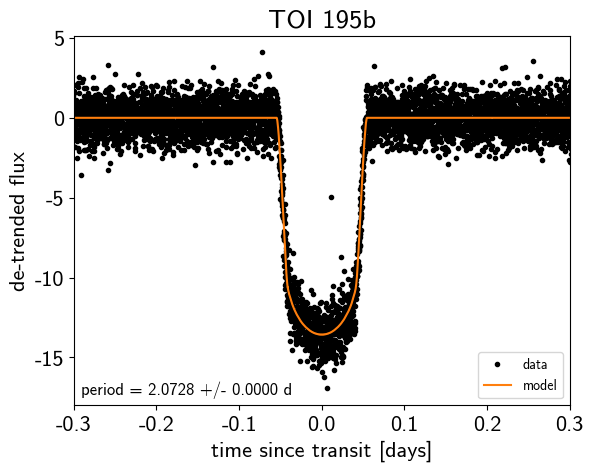

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

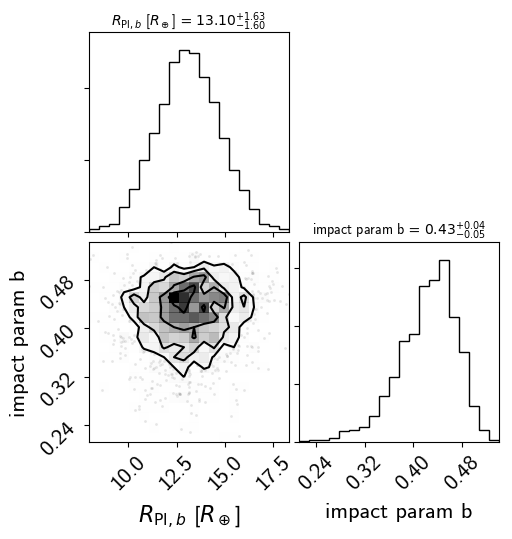

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

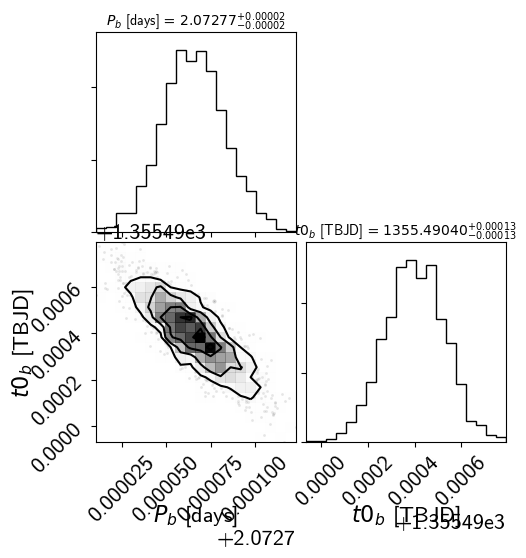

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

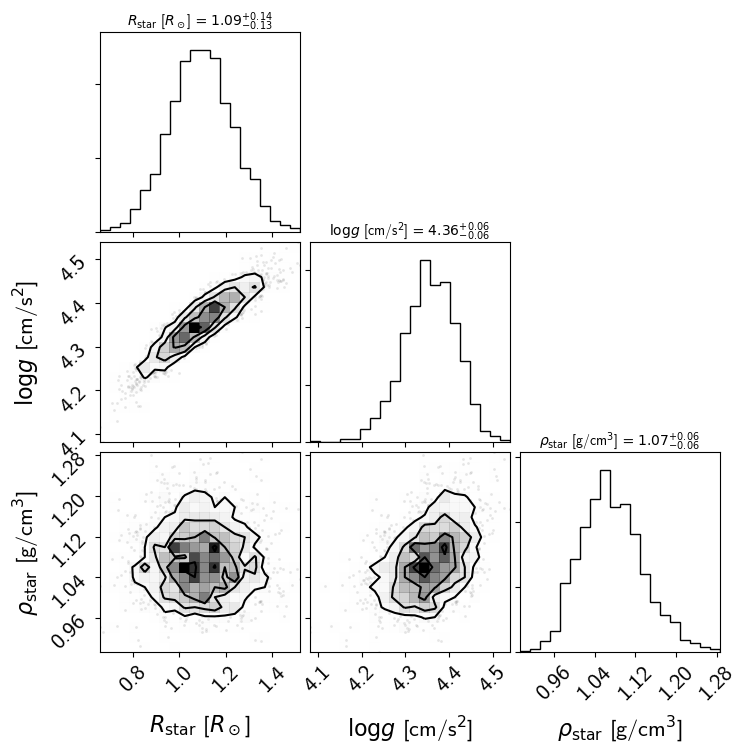

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3